# Polymarket × StatsBomb Data Matching

## Overview

This notebook experiments with maching soccer prediction market data (Polymarket) to match event data (StatsBomb). The goal is to explore possible ways these datasets can be linked and to surface preliminary observaitons. It's mainly a sandbox for testing ideas and testing logic. Use the sections below to navigate the notebook.

## Dataset Characteristics

### Polymarket 2024
- **1,054 markets** 
- **Market types:** Match outcomes, team futures, tournament winners, etc. 
- **Temporal:** Markets created 0-7 days before events
- **Volume:** Total betting volume across markets (data available but not analyzed yet)

### StatsBomb 2024
- **153 matches** across 4 competitions
- **Competitions:** UEFA Euro (51), AFCON (52), Copa America (32), Bundesliga (18)
- **Coverage:** 88% international tournaments, 12% club matches
- **Players:** 1,927 unique players across lineups

### Why 2024?
- Best temporal overlap: both datasets have substantial 2024 coverage
- 2024 = tournament-heavy year (Euro, Copa America, AFCON) where Polymarket is most active
- 2025 is incomplete and 2023 has fewer Polymarket markets 

## Matching Pipeline

### Team Detection
Fuzzy matching with strict guardrails:
- **National teams:** Exact full name required ("United States" only, not "USA" or "US")
- **Club teams:** Partial match on distinctive parts ("Bayern" → "Bayern Munich", "Dortmund" → "Borussia Dortmund")
- **Common words excluded:** FC, United, City, Union (prevents "Union Berlin" matching "Union Saint-Gilloise")
- **Multi-word clubs:** All distinctive parts required (prevents "Borussia Mönchengladbach" matching "Borussia Dortmund")

### Player Detection
Strict matching to avoid false positives:
- **2-name players:** Both names required ("Lionel Messi", not "Messi")
- **3+ name players:** First + last name within 50 characters ("Cristiano Ronaldo" matches "Cristiano Ronaldo dos Santos Aveiro")
- **No single-name matches:** Prevents "Haaland" matching "Erling Haaland"

## Observations

### Match Statistics
- 9 head-to-head (both teams detected) 
- 129 single-team (one team detected) 
- 15 player props 

### Tournament Bias 
88% of StatsBomb matches are international tournaments vs. 12% club. Limits generalizability to regular season club soccer. 

## Data Quality

**Strengths:** 
- Clean match-to-market mappings for 130+ markets 

**Limitations**
- No major leagues: Premier League, La Liga, Serie A absent 
- Small sample (130+) limits statistical power 
- Tournament-only bias 

## Analysis Considerations

1. **Match-level correlations:** xG vs. betting volume, possession vs. market odds
2. **Team aggregations:** Total xG across all Argentina matches vs. "Will Argentina win Copa America?" market
3. The datasets don't enable predictive modeling (sample too small) or cross-league comparisons (only 4 competitions)

In [2]:
!pip install fuzzywuzzy python-Levenshtein
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from collections import Counter
from fuzzywuzzy import fuzz, process
from pathlib import Path
import os
import warnings
import re
    
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Suppress common warnings for cleaner notebook output
warnings.filterwarnings("ignore")

  Obtaining dependency information for fuzzywuzzy from https://files.pythonhosted.org/packages/43/ff/74f23998ad2f93b945c0309f825be92e04e0348e062026998b5eefef4c33/fuzzywuzzy-0.18.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for python-Levenshtein from https://files.pythonhosted.org/packages/7b/5b/26e3cca2589252ceabf964ba81514e6f48556553c9c2766e1a0fdceec696/python_levenshtein-0.27.3-py3-none-any.whl.metadata
  Obtaining dependency information for Levenshtein==0.27.3 from https://files.pythonhosted.org/packages/1d/f4/fe665c8e5d8ebe4266807e43af72db9d4f84d4f513ea86eacca3aaf5f77b/levenshtein-0.27.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for rapidfuzz<4.0.0,>=3.9.0 from https://files.pythonhosted.org/packages/2d/ab/f1181f500c32c8fcf7c966f5920c7e56b9b1d03193386d19c956505c312d/rapidfuzz-3.14.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.6/158.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [3]:
# Load Polymarket data
DATA_DIR = Path("..") / "data" 
polymarket_df = pd.read_parquet(DATA_DIR / "Polymarket/soccer_markets.parquet")

# Convert date columns
polymarket_df['end_date'] = pd.to_datetime(polymarket_df['end_date'])
polymarket_df['created_at'] = pd.to_datetime(polymarket_df['created_at'])

polymarket_df.head()

,market_id,question,slug,event_slug,category,volume,active,closed,created_at,end_date
0,242920,Will Ukraine qualify for the 2022 FIFA World Cup?,will-ukraine-qualify-to-the-2022-fifa-world-cup,will-ukraine-qualify-to-the-2022-fifa-world-cup,Sports,4766.88,True,True,2022-04-06 07:51:48,2022-06-30
1,244963,UEFA Europa League final: Who will win Eintracht vs. Rangers?,uefa-europa-league-final-who-will-win-eintracht-vs-rangers,uefa-europa-league-final-who-will-win-eintracht-vs-rangers,Sports,1543.29,True,True,2022-05-18 14:16:53,2022-05-18
2,246443,Soccer: Who will win the United States vs. Uruguay international friendly game on June 5?,soccer-who-will-win-the-united-states-vs-uruguay-international-friendly-game-on-june-5,soccer-who-will-win-the-united-states-vs-uruguay-international-friendly-game-on-june-5,Sports,1363.07,True,True,2022-06-05 12:45:16,2022-06-05
3,246490,UEFA Nations League: Who will win the Germany vs. England game on June 7?,uefa-nations-league-who-will-win-the-germany-vs-england-game-on-june-7,uefa-nations-league-who-will-win-the-germany-vs-england-game-on-june-7,Sports,1031.58,True,True,2022-06-06 17:09:19,2022-06-07
4,246661,2022 Wimbledon Championships: Who will win Kyrgios vs. Nadal?,2022-wimbledon-championships-who-will-win-kyrgios-vs-nadal,2022-wimbledon,Sports,3098.29,True,True,2022-07-06 19:33:08,2022-07-08


In [4]:
statsbomb_df = pd.read_parquet(DATA_DIR / "StatsBomb/matches.parquet")
statsbomb_df['match_date'] = pd.to_datetime(statsbomb_df['match_date'])
statsbomb_df.head()

,match_id,match_date,match_week,match_status,match_status_360,kickoff,home_score,away_score,competition_id,competition,competition_stage,season_id,season,home_team_id,home_team,home_managers,away_team_id,away_team,away_managers,stadium_id,stadium,referee_id,referee,last_updated,last_updated_360,data_version,shot_fidelity_version,xy_fidelity_version,competition_name,gender,is_youth,is_international,country_name,season_name,match_updated,match_available_360
0,9880,2018-04-14,32,available,scheduled,16:15:00,2,1,11,La Liga,Regular Season,1,2017/2018,217,Barcelona,"[{""id"":227,""name"":""Ernesto Valverde Tejedor"",""nickname"":""Ernesto Valverde"",""dob"":""1964-02-09"",""c...",207,Valencia,"[{""id"":211,""name"":""Marcelino García Toral"",""nickname"":""Marcelino"",""dob"":""1965-08-14"",""country"":{...",342.0,Spotify Camp Nou,2728.0,Carlos del Cerro Grande,2023-02-08T17:23:53.901920,2021-06-13T16:17:31.694,1.1.0,2,2,La Liga,male,False,False,Spain,2017/2018,2025-07-14T10:01:16.674864,None
1,9912,2018-04-29,35,available,scheduled,20:45:00,2,4,11,La Liga,Regular Season,1,2017/2018,219,RC Deportivo La Coruña,"[{""id"":371,""name"":""Clarence Seedorf"",""nickname"":null,""dob"":""1976-04-01"",""country"":{""id"":160,""nam...",217,Barcelona,"[{""id"":227,""name"":""Ernesto Valverde Tejedor"",""nickname"":""Ernesto Valverde"",""dob"":""1964-02-09"",""c...",4658.0,Estadio Abanca-Riazor,2602.0,Ricardo De Burgos Bengoetxea,2022-12-05T14:42:44.641092,2021-06-13T16:17:31.694,1.1.0,2,2,La Liga,male,False,False,Spain,2017/2018,2025-07-14T10:01:16.674864,None
2,9924,2018-05-06,36,available,scheduled,20:45:00,2,2,11,La Liga,Regular Season,1,2017/2018,217,Barcelona,"[{""id"":227,""name"":""Ernesto Valverde Tejedor"",""nickname"":""Ernesto Valverde"",""dob"":""1964-02-09"",""c...",220,Real Madrid,"[{""id"":56,""name"":""Zinédine Zidane"",""nickname"":null,""dob"":""1972-06-23"",""country"":{""id"":78,""name"":...",342.0,Spotify Camp Nou,2608.0,Alejandro José Hernández Hernández,2022-12-01T03:25:12.063586,2021-06-13T16:17:31.694,1.1.0,2,2,La Liga,male,False,False,Spain,2017/2018,2025-07-14T10:01:16.674864,None
3,9855,2018-03-18,29,available,scheduled,16:15:00,2,0,11,La Liga,Regular Season,1,2017/2018,217,Barcelona,"[{""id"":227,""name"":""Ernesto Valverde Tejedor"",""nickname"":""Ernesto Valverde"",""dob"":""1964-02-09"",""c...",215,Athletic Club,"[{""id"":210,""name"":""José Ángel Ziganda Lacunza"",""nickname"":""Cuco Ziganda"",""dob"":""1966-10-01"",""cou...",342.0,Spotify Camp Nou,2575.0,Santiago Jaime Latre,2022-12-01T02:33:31.178193,2021-06-13T16:17:31.694,1.1.0,2,2,La Liga,male,False,False,Spain,2017/2018,2025-07-14T10:01:16.674864,None
4,9827,2018-03-01,26,available,scheduled,21:00:00,1,1,11,La Liga,Regular Season,1,2017/2018,208,Las Palmas,"[{""id"":220,""name"":""Francisco Jémez Martín"",""nickname"":""Paco Jémez"",""dob"":""1970-04-18"",""country"":...",217,Barcelona,"[{""id"":227,""name"":""Ernesto Valverde Tejedor"",""nickname"":""Ernesto Valverde"",""dob"":""1964-02-09"",""c...",357.0,Estadio de Gran Canaria,180.0,Antonio Miguel Mateu Lahoz,2022-08-04T17:18:06.540844,2021-06-13T16:17:31.694,1.1.0,2,2,La Liga,male,False,False,Spain,2017/2018,2025-07-14T10:01:16.674864,None


In [5]:
# Check temporal coverage of both datasets to find overlap periods
print("POLYMARKET DATA:")
print("=" * 80)
print(f"Earliest market created: {polymarket_df['created_at'].min()}")
print(f"Latest market created: {polymarket_df['created_at'].max()}")
print(f"Earliest end_date: {polymarket_df['end_date'].min()}")
print(f"Latest end_date: {polymarket_df['end_date'].max()}")

print("\n\nSTATSBOMB DATA:")
print("=" * 80)
print(f"Earliest match: {statsbomb_df['match_date'].min()}")
print(f"Latest match: {statsbomb_df['match_date'].max()}")

# Identify overlapping time period where both datasets have data
print("\n\nOVERLAP ANALYSIS:")
print("=" * 80)
pm_start = polymarket_df['end_date'].min()
pm_end = polymarket_df['end_date'].max()
sb_start = statsbomb_df['match_date'].min()
sb_end = statsbomb_df['match_date'].max()

overlap_start = max(pm_start, sb_start)
overlap_end = min(pm_end, sb_end)

if overlap_start < overlap_end:
    print(f"Overlap period: {overlap_start.date()} to {overlap_end.date()}")
    print(f"Duration: {(overlap_end - overlap_start).days} days")
else:
    print("No overlap between datasets")

POLYMARKET DATA:
Earliest market created: 2021-04-12 19:50:01
Latest market created: 2025-12-09 15:31:51
Earliest end_date: 2021-04-13 00:00:00
Latest end_date: 2026-07-20 00:00:00


STATSBOMB DATA:
Earliest match: 1958-06-24 00:00:00
Latest match: 2025-07-27 00:00:00


OVERLAP ANALYSIS:
Overlap period: 2021-04-13 to 2025-07-27
Duration: 1566 days


In [6]:
# Extract year from dates for temporal analysis
polymarket_df['year'] = polymarket_df['end_date'].dt.year
statsbomb_df['year'] = statsbomb_df['match_date'].dt.year

# Find years present in both datasets
polymarket_years = set(polymarket_df['year'].unique())
statsbomb_years = set(statsbomb_df['year'].unique())
overlap_years = sorted(polymarket_years & statsbomb_years)

print(f"Years in both datasets: {overlap_years}")

if overlap_years:
    # Filter both datasets to years where we have data from both sources
    polymarket_overlap = polymarket_df[polymarket_df['year'].isin(overlap_years)].copy()
    statsbomb_overlap = statsbomb_df[statsbomb_df['year'].isin(overlap_years)].copy()
    
    print(f"\nPolymarket markets in overlap years: {len(polymarket_overlap)}")
    print(f"StatsBomb matches in overlap years: {len(statsbomb_overlap)}")
    
    # Show year-by-year breakdown to identify best year for analysis
    print("\nBreakdown by year:")
    for year in overlap_years:
        pm_count = len(polymarket_overlap[polymarket_overlap['year'] == year])
        sb_count = len(statsbomb_overlap[statsbomb_overlap['year'] == year])
        print(f"  {year}: {pm_count} markets, {sb_count} matches")
else:
    print("No overlapping years")

Years in both datasets: [2021.0, 2022.0, 2023.0, 2024.0, 2025.0]

Polymarket markets in overlap years: 7799
StatsBomb matches in overlap years: 686

Breakdown by year:
  2021.0: 98 markets, 204 matches
  2022.0: 54 markets, 193 matches
  2023.0: 69 markets, 105 matches
  2024.0: 1054 markets, 153 matches
  2025.0: 6524 markets, 31 matches


In [7]:
# Focus analysis on 2024 - the year with most data overlap
pm_2024 = polymarket_df[polymarket_df['year'] == 2024].copy()
sb_2024 = statsbomb_df[statsbomb_df['year'] == 2024].copy()

# Check which competitions StatsBomb covers in 2024
print("2024 COMPETITIONS:")
print(sb_2024['competition'].value_counts())

# Sample Polymarket questions to understand market types
print("\n2024 SAMPLE MARKETS:")
print(pm_2024['question'].sample(10).tolist())

2024 COMPETITIONS:
African Cup of Nations    52
UEFA Euro                 51
Copa America              32
1. Bundesliga             18
Name: competition, dtype: int64

2024 SAMPLE MARKETS:
['Will LOSC Lille beat Real Madrid?', 'Will West Ham win on 2024-11-09?', 'Will Newcastle win on 2024-12-21?', 'Will Young Boys beat Inter Milan?', 'Will Southampton vs. Ipswich Town end in a draw?', 'Will Liverpool win on 2024-11-24?', 'Will Bayer Leverkusen beat Stade Brestois?', 'Will Bayern Munich beat Benfica?', 'Will West Ham win on 2024-11-02?', 'Will Jude Bellingham be Euro 2024 top scorer?']


In [8]:
# Get all unique teams from StatsBomb 2024
sb_teams_2024 = pd.concat([
    sb_2024[['home_team_id', 'home_team']].rename(columns={'home_team_id': 'team_id', 'home_team': 'team_name'}),
    sb_2024[['away_team_id', 'away_team']].rename(columns={'away_team_id': 'team_id', 'away_team': 'team_name'})
]).drop_duplicates().sort_values('team_name').reset_index(drop=True)

print(f"Total unique teams in StatsBomb 2024: {len(sb_teams_2024)}")
print("\nAll StatsBomb teams:")
print(sb_teams_2024)

# Create a list for easy searching
sb_team_names = sb_teams_2024['team_name'].tolist()
sb_team_names_lower = [name.lower() for name in sb_team_names]

Total unique teams in StatsBomb 2024: 82

All StatsBomb teams:
    team_id      team_name
0       906        Albania
1      4898        Algeria
2      4901         Angola
3       779      Argentina
4       172       Augsburg
..      ...            ...
77     3563      Venezuela
78      174  VfB Stuttgart
79      176  Werder Bremen
80      179      Wolfsburg
81     4963         Zambia

[82 rows x 2 columns]


In [9]:
def find_statsbomb_teams_in_text_fuzzy(text, sb_team_names):
    """
    Match team names with fuzzy logic, being strict about country names.
    - Club teams: allow partial matches and nicknames
    - National teams: require full name only
    """
    if pd.isna(text):
        return []
    
    text_lower = text.lower()
    found_teams = []
    
    # List of national teams that should ONLY match on full name
    national_teams = {
        'Albania', 'Algeria', 'Angola', 'Argentina', 'Austria', 'Belgium', 
        'Bolivia', 'Brazil', 'Burkina Faso', 'Cameroon', 'Canada', 
        'Cape Verde Islands', 'Chile', 'Colombia', 'Congo DR', 'Costa Rica', 
        'Croatia', 'Czech Republic', 'Côte d\'Ivoire', 'Denmark', 'Ecuador', 
        'Egypt', 'England', 'Equatorial Guinea', 'France', 'Gambia', 'Georgia', 
        'Germany', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Hungary', 'Italy', 
        'Jamaica', 'Mali', 'Mauritania', 'Mexico', 'Morocco', 'Mozambique', 
        'Namibia', 'Netherlands', 'Nigeria', 'Panama', 'Paraguay', 'Peru', 
        'Poland', 'Portugal', 'Romania', 'Scotland', 'Senegal', 'Serbia', 
        'Slovakia', 'Slovenia', 'South Africa', 'Spain', 'Switzerland', 
        'Tanzania', 'Tunisia', 'Turkey', 'Ukraine', 'United States', 'Uruguay', 
        'Venezuela', 'Wales', 'Zambia'
    }
    
    for team_name in sb_team_names:
        team_lower = team_name.lower()
        
        # For national teams, ONLY allow exact full name match
        if team_name in national_teams:
            pattern = r'\b' + re.escape(team_lower) + r'\b'
            if re.search(pattern, text_lower):
                found_teams.append(team_name)
            continue
        
        # For club teams, try exact match first
        pattern = r'\b' + re.escape(team_lower) + r'\b'
        if re.search(pattern, text_lower):
            found_teams.append(team_name)
            continue
        
        # For multi-word club names, only match if ALL distinctive parts appear
        team_parts = team_lower.split()
        
        if len(team_parts) >= 2:
            common_words = {'fc', 'cf', 'ac', 'sc', 'united', 'city', 'athletic', 
                          'sporting', 'real', 'club', 'de', 'del', 'la', 'el',
                          'vfb', 'fsv', 'rb', '98', '05', 'islands', 'dr', 'union'}
            
            distinctive_parts = [p for p in team_parts if p not in common_words and len(p) >= 5]
            
            # ALL distinctive parts must appear in text
            if distinctive_parts:
                all_parts_found = True
                for part in distinctive_parts:
                    part_pattern = r'\b' + re.escape(part) + r'\b'
                    if not re.search(part_pattern, text_lower):
                        all_parts_found = False
                        break
                
                if all_parts_found:
                    found_teams.append(team_name)
        
        elif len(team_parts) == 1 and len(team_lower) >= 5:
            part_pattern = r'\b' + re.escape(team_lower) + r'\b'
            if re.search(part_pattern, text_lower):
                found_teams.append(team_name)
    
    # Handle club nicknames only (full match required, not partial)
    club_nickname_map = {
        'leverkusen': 'Bayer Leverkusen',
        'dortmund': 'Borussia Dortmund',
        'gladbach': 'Borussia Mönchengladbach',
        'monchengladbach': 'Borussia Mönchengladbach',
        'mönchengladbach': 'Borussia Mönchengladbach',
        'frankfurt': 'Eintracht Frankfurt',
        'koln': 'FC Köln',
        'köln': 'FC Köln',
        'cologne': 'FC Köln',
        'mainz': 'FSV Mainz 05',
        'heidenheim': 'FC Heidenheim',
        'leipzig': 'RB Leipzig',
        'stuttgart': 'VfB Stuttgart',
        'bremen': 'Werder Bremen',
        'bayern': 'Bayern Munich',
    }
    
    for nickname, full_name in club_nickname_map.items():
        if full_name in sb_team_names and full_name not in found_teams:
            pattern = r'\b' + re.escape(nickname) + r'\b'
            if re.search(pattern, text_lower):
                found_teams.append(full_name)
    
    return list(dict.fromkeys(found_teams))

# Re-run team detection with stricter rules
pm_2024['found_teams'] = pm_2024['question'].apply(
    lambda x: find_statsbomb_teams_in_text_fuzzy(x, sb_team_names)
)

pm_2024['found_teams_slug'] = pm_2024['slug'].apply(
    lambda x: find_statsbomb_teams_in_text_fuzzy(x, sb_team_names)
)

pm_2024['all_found_teams'] = pm_2024.apply(
    lambda row: list(set(row['found_teams'] + row['found_teams_slug'])), 
    axis=1
)

pm_2024['num_teams_found'] = pm_2024['all_found_teams'].apply(len)

# Test the problem cases
test_cases = [
    "Will Juventus beat Stuttgart?",
    "Will the match between Fenerbahce vs. Union Saint-Gilloise end in a draw?",
    "Will Atletico Madrid vs Borussia Dortmund be a draw?"
]

print("Testing problem cases:")
for test in test_cases:
    found = find_statsbomb_teams_in_text_fuzzy(test, sb_team_names)
    print(f"\n'{test}'")
    print(f"  → {found}")

print("\n\nOverall detection results:")
print(pm_2024['num_teams_found'].value_counts().sort_index())

Testing problem cases:

'Will Juventus beat Stuttgart?'
  → ['VfB Stuttgart']

'Will the match between Fenerbahce vs. Union Saint-Gilloise end in a draw?'
  → []

'Will Atletico Madrid vs Borussia Dortmund be a draw?'
  → ['Borussia Dortmund']


Overall detection results:
0    916
1    129
2      9
Name: num_teams_found, dtype: int64


In [10]:
# Load player lineup data
lineups_path = DATA_DIR / "Statsbomb/lineups.parquet"
lineups = pd.read_parquet(lineups_path)

# Filter to 2024 matches only
match_ids_2024 = sb_2024['match_id'].unique()
lineups_2024 = lineups[lineups['match_id'].isin(match_ids_2024)].copy()

print(f"Loaded {len(lineups_2024)} player appearances across {len(match_ids_2024)} matches")
print(f"Unique players: {lineups_2024['player_name'].nunique()}")

lineups_2024.head(10)

Loaded 9651 player appearances across 153 matches
Unique players: 1927


,match_id,team_id,player_id,player_name,player_nickname,jersey_number,country_id,country_name,team_name,position_name,from_time,to_time,from_period,to_period,card_time,card_type,card_reason
96851,3895194,172,9198,Niklas Dorsch,None,30,85.0,Germany,Augsburg,Center Defensive Midfield,00:00,None,1.0,NaN,43:13,Yellow Card,Foul Committed
96852,3895194,172,25118,Iago Amaral Borduchi,Iago,22,31.0,Brazil,Augsburg,Left Back,00:00,87:09,1.0,2.0,18:43,Yellow Card,Bad Behaviour
96853,3895194,172,25118,Iago Amaral Borduchi,Iago,22,31.0,Brazil,Augsburg,Left Center Back,87:09,None,2.0,NaN,18:43,Yellow Card,Bad Behaviour
96854,3895194,172,30401,Ruben Vargas,None,16,221.0,Switzerland,Augsburg,Center Attacking Midfield,00:00,61:26,1.0,2.0,17:56,Yellow Card,Bad Behaviour
96855,3895194,904,8804,Jonas Hofmann,None,7,85.0,Germany,Bayer Leverkusen,Right Attacking Midfield,00:00,None,1.0,NaN,45:24,Yellow Card,Foul Committed
96856,3895202,904,8221,Jonathan Tah,None,4,85.0,Germany,Bayer Leverkusen,Center Back,00:00,None,1.0,NaN,10:55,Yellow Card,Foul Committed
96857,3895202,904,40724,Florian Wirtz,None,10,85.0,Germany,Bayer Leverkusen,Left Attacking Midfield,00:00,None,1.0,NaN,65:47,Yellow Card,Foul Committed
96858,3895202,904,49337,Josip Stanišić,None,2,56.0,Croatia,Bayer Leverkusen,Right Center Back,00:00,None,1.0,NaN,37:02,Yellow Card,Foul Committed
96859,3895202,182,8769,Xaver Schlager,None,24,15.0,Austria,RB Leipzig,Left Defensive Midfield,00:00,None,1.0,NaN,86:13,Yellow Card,Foul Committed
96860,3895202,182,39167,Xavi Simons,None,20,160.0,Netherlands,RB Leipzig,Right Attacking Midfield,00:00,62:40,1.0,2.0,70:47,Yellow Card,Foul Committed


In [11]:
# Get all unique players from 2024 matches
if 'player_name' in lineups_2024.columns:
    players_2024 = lineups_2024[['player_name', 'team_name']].drop_duplicates().sort_values('player_name')
    
    print(f"UNIQUE PLAYERS IN STATSBOMB 2024:")
    print("=" * 80)
    print(f"Total: {len(players_2024)}")
    
    # Show sample
    print("\nSample players:")
    print(players_2024.head(10))
    
    # Create list for searching
    player_names = players_2024['player_name'].tolist()
    player_names_lower = [name.lower() for name in player_names]
    
else:
    print("'player_name' column not found. Available columns:")
    print(lineups_2024.columns.tolist())
    print("\nPlease check the column names and adjust accordingly")

UNIQUE PLAYERS IN STATSBOMB 2024:
Total: 2011

Sample players:
                            player_name     team_name
144568                   Aaron Ramsdale       England
110480                   Aaron Tshibola      Congo DR
144823       Aarón Moisés Cruz Esquivel    Costa Rica
151784               Abdallah Dipo Sima       Senegal
146696                 Abdelkabir Abqar       Morocco
110049            Abdessamad Ezzalzouli       Morocco
137962                       Abdi Banda      Tanzania
113887  Abdiel Armando Ayarza Cocanegra        Panama
109223                     Abdou Diallo       Senegal
109246            Abdoul Fessal Tapsoba  Burkina Faso


In [12]:
def find_players_in_text_strict(text, player_names):
    """
    Match player names with strict requirements to avoid false positives.
    - 2-name players: requires full name (e.g., "Lionel Messi")
    - 3+ name players: requires first + last name (e.g., "Cristiano Ronaldo" for "Cristiano Ronaldo dos Santos")
    - No single-name matches allowed
    """
    if pd.isna(text):
        return []
    
    text_lower = text.lower()
    found_players = []
    
    for player_name in player_names:
        player_lower = player_name.lower()
        name_parts = player_name.split()
        
        # Try exact full name match
        full_name_pattern = r'\b' + re.escape(player_lower) + r'\b'
        if re.search(full_name_pattern, text_lower):
            found_players.append(player_name)
            continue
        
        # For players with 3+ names, allow first + last name match
        # (handles cases like "Cristiano Ronaldo" matching "Cristiano Ronaldo dos Santos Aveiro")
        if len(name_parts) >= 3:
            first_name = name_parts[0]
            last_name = name_parts[-1]
            
            first_pattern = r'\b' + re.escape(first_name.lower()) + r'\b'
            last_pattern = r'\b' + re.escape(last_name.lower()) + r'\b'
            
            if re.search(first_pattern, text_lower) and re.search(last_pattern, text_lower):
                # Check that first and last names appear close together (within 50 chars)
                # to avoid matching unrelated occurrences
                first_matches = [m.start() for m in re.finditer(first_pattern, text_lower)]
                last_matches = [m.start() for m in re.finditer(last_pattern, text_lower)]
                
                for first_pos in first_matches:
                    for last_pos in last_matches:
                        if abs(first_pos - last_pos) <= 50:
                            found_players.append(player_name)
                            break
                    if player_name in found_players:
                        break
    
    return found_players

# Detect players in market text
pm_2024['found_players_question'] = pm_2024['question'].apply(
    lambda x: find_players_in_text_strict(x, player_names)
)

pm_2024['found_players_slug'] = pm_2024['slug'].apply(
    lambda x: find_players_in_text_strict(x, player_names)
)

pm_2024['all_found_players'] = pm_2024.apply(
    lambda row: list(set(row['found_players_question'] + row['found_players_slug'])),
    axis=1
)

pm_2024['num_players_found'] = pm_2024['all_found_players'].apply(len)

# Check results
print("Player detection results:")
print(pm_2024['num_players_found'].value_counts().sort_index())

markets_with_players = pm_2024[pm_2024['num_players_found'] > 0]
if len(markets_with_players) > 0:
    print(f"\nFound {len(markets_with_players)} markets mentioning players\n")
    sample = markets_with_players.sample(min(10, len(markets_with_players)))
    
    for idx, row in sample.iterrows():
        print(f"{row['question'][:65]}")
        print(f"  → {row['all_found_players']}\n")

Player detection results:
0    1039
1      15
Name: num_players_found, dtype: int64

Found 15 markets mentioning players

Will Cody Gakpo be Euro 2024 top scorer?
  → ['Cody Mathès Gakpo']

Will Phil Foden be Euro 2024 top scorer?
  → ['Phil Foden']

Will Antoine Griezmann be Euro 2024 top scorer?
  → ['Antoine Griezmann']

Will Harry Kane be Player of the Tournament for Euro 2024?
  → ['Harry Kane']

Will Bukayo Saka be Player of the Tournament for Euro 2024?
  → ['Bukayo Saka']

Will Florian Wirtz be Euro 2024 top scorer?
  → ['Florian Wirtz']

Will Toni Kroos be Player of the Tournament for Euro 2024?
  → ['Toni Kroos']

Will Jamal Musiala be Euro 2024 top scorer?
  → ['Jamal Musiala']

Will Harry Kane be Euro 2024 top scorer?
  → ['Harry Kane']

Will Jude Bellingham be Euro 2024 top scorer?
  → ['Jude Bellingham']



In [13]:
# Prepare export with all relevant columns
export_cols = ['market_id', 'question', 'slug', 'category', 'volume', 
               'active', 'closed', 'created_at', 'end_date', 'year']

# Add detection columns
export_cols.extend(['num_teams_found', 'all_found_teams', 
                    'num_players_found', 'all_found_players'])

# Only keep columns that actually exist
export_cols = [c for c in export_cols if c in pm_2024.columns]

results_df = pm_2024[export_cols].copy()

# Convert lists to semicolon-separated strings for CSV compatibility
for col in ['all_found_players', 'all_found_teams']:
    if col in results_df.columns:
        results_df[col] = results_df[col].apply(
            lambda x: '; '.join(x) if isinstance(x, list) and len(x) > 0 else ''
        )

# Save to CSV
out_dir = Path('..') / 'data' / 'Polymarket'
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / 'pm_2024_detection_results.csv'
results_df.to_csv(out_path, index=False)

print(f"Exported {len(results_df)} markets to: {out_path}")
print(f"Columns: {', '.join(results_df.columns)}")

Exported 1054 markets to: ../data/Polymarket/pm_2024_detection_results.csv
Columns: market_id, question, slug, category, volume, active, closed, created_at, end_date, year, num_teams_found, all_found_teams, num_players_found, all_found_players


# Validate Data

In [14]:
# Check what types of markets we actually detected
single_team = pm_2024[pm_2024['num_teams_found'] == 1].copy()

# Sample to manually verify
print("Single-team market samples:")
print(single_team[['question', 'all_found_teams']].sample(20))

# Common issues to look for:
# - "Will Argentina win Copa America?" ✓ CORRECT
# - "Argentina to reach finals?" ✓ CORRECT  
# - "Argentina vs Brazil draw?" ✗ WRONG (should have 2 teams)
# - "Top scorer from Argentina?" ✗ WRONG (player prop, not team outcome)

# Filter to only tournament outcome markets
tournament_keywords = ['win', 'wins', 'winner', 'champion', 'qualify', 
                       'advance', 'reach', 'final', 'semi-final']

single_team['is_tournament_market'] = single_team['question'].str.lower().str.contains(
    '|'.join(tournament_keywords), 
    regex=True
)

print(f"\nActual tournament markets: {single_team['is_tournament_market'].sum()}")

Single-team market samples:
                                                                  question  \
341   Will the match between Feyenoord vs. Bayer Leverkusen end in a draw?   
35                    Will Atletico Madrid vs Borussia Dortmund be a draw?   
451                      Will Morocco win Gold in Men's Football (Soccer)?   
740                                   Will Aston Villa beat Bayern Munich?   
1241                                       Will Young Boys beat Stuttgart?   
1069                                     Will Inter Milan beat RB Leipzig?   
741                                   Will Bayern Munich beat Aston Villa?   
610                      Will Real Madrid vs. VfB Stuttgart end in a draw?   
1071      Will the match between Inter Milan and RB Leipzig end in a draw?   
404                             Champions League: Arsenal vs Bayern Munich   
833                                        Will Liverpool beat RB Leipzig?   
311                           Olympi

### What does this mean

- Only 35 are actual tournament markets (winner/qualify/medal markets)
- 94 are match outcome markets where fuzzy matching failed to detect the second team

***For example:***
- "Will Atletico Madrid vs Borussia Dortmund be a draw?" 
  → Detected: [Borussia Dortmund] 
  → MISSED: Atletico Madrid

- "Will VfB Stuttgart beat Real Madrid?"
  → Detected: [VfB Stuttgart]
  → MISSED: Real Madrid (not in StatsBomb 2024!)
  
***This means:***

- 9 head-to-head matches are undercounted - we likely have 50-70 actual h2h markets
- 129 single-team count is inflated - most are failed 2-team detections, not tournament futures

***This is because:***
- Real Madrid, Atletico Madrid, Juventus, etc. are NOT in StatsBomb 2024
    - StatsBomb 2024 only has: Euro, Copa America, AFCON, Bundesliga
    - No La Liga, Serie A, Premier League, Champions League club matches
    - Our fuzzy matcher can't find teams that don't exist in the dataset

- Polymarket data includes Champions League, but StatsBomb doesn't
    - Markets like "Arsenal vs Bayern Munich" have Bayern (Bundesliga) but not Arsenal (no PL data), creating asymmetric detections


In [15]:
# rectify

# Separate club vs international markets
def classify_market_context(question, slug):
    """Determine if this is club or international competition"""
    text = f"{question} {slug}".lower()
    
    # International tournaments
    if any(x in text for x in ['euro 2024', 'copa america', 'afcon', 
                                'africa cup', 'olympic', 'world cup']):
        return 'international'
    
    # Club competitions
    if any(x in text for x in ['champions league', 'europa league', 
                                'bundesliga', 'premier league', 'la liga']):
        return 'club'
    
    return 'unknown'

pm_2024['market_context'] = pm_2024.apply(
    lambda row: classify_market_context(row['question'], row['slug']),
    axis=1
)

print(pm_2024['market_context'].value_counts())

unknown          966
international     54
club              34
Name: market_context, dtype: int64


### Resulted in too many unkown, meaning our logic is too strict.

In [16]:
def classify_market_context(question, slug):
    """Determine if this is club or international competition"""
    text = f"{question} {slug}".lower()
    
    # International tournaments - EXPANDED keywords
    international_keywords = [
        'euro 2024', 'euro2024', 'uefa euro',
        'copa america', 'copa américa', 
        'afcon', 'african cup', 'africa cup',
        'olympic', 'olympics',
        'world cup', 'fifa',
        'nations league',
        # Add tournament-specific phrases
        'tournament', 'qualify', 'qualification'
    ]
    
    if any(keyword in text for keyword in international_keywords):
        return 'international'
    
    # Club competitions - EXPANDED
    club_keywords = [
        'champions league', 'ucl',
        'europa league', 'uel',
        'conference league',
        'bundesliga', 'premier league', 'la liga', 'serie a', 'ligue 1',
        'epl', 'pl',
    ]
    
    if any(keyword in text for keyword in club_keywords):
        return 'club'
    
    # If it mentions 2 teams and has match language, likely a match market
    match_patterns = ['vs.', 'vs', 'versus', 'beat', 'win on', 'draw']
    if any(pattern in text for pattern in match_patterns):
        return 'match_market'  # New category
    
    return 'unknown'

pm_2024['market_context'] = pm_2024.apply(
    lambda row: classify_market_context(row['question'], row['slug']),
    axis=1
)

print("Market context breakdown:")
print(pm_2024['market_context'].value_counts())

# Sample the unknowns to see what we're missing
print("\n\nSample 'unknown' markets:")
print(pm_2024[pm_2024['market_context'] == 'unknown']['question'].sample(min(20, len(pm_2024[pm_2024['market_context'] == 'unknown']))))

Market context breakdown:
match_market     555
club             397
international     54
unknown           48
Name: market_context, dtype: int64


Sample 'unknown' markets:
870                              Will the Inter Miami win the 2024 MLS Cup?
881                                 Will Charlotte FC win the 2024 MLS Cup?
874                              Will the Seattle Sounders win the MLS Cup?
875                                     Will FC Cincinnati win the MLS Cup?
1259    Will Manchester United and Bournemouth combine for 3 or more goals?
390                      Will France win Gold in Women's Football (Soccer)?
1255           Will Ipswich Town and Newcastle combine for 3 or more goals?
873                                    Will Los Angeles FC win the MLS Cup?
876                                    Will Real Salt Lake win the MLS Cup?
1256      Will Brentford and Nottingham Forest combine for 3 or more goals?
1261               Will Fulham and Southampton combine for 4 or mor

In [17]:
# For markets where we detected teams, 
# check which tournament those teams played in StatsBomb

def map_team_to_tournament(team_name, sb_2024):
    """Find which tournament(s) a team played in"""
    team_matches = sb_2024[
        (sb_2024['home_team'] == team_name) | 
        (sb_2024['away_team'] == team_name)
    ]
    
    if len(team_matches) == 0:
        return None
    
    # Return the competition(s) they played in
    tournaments = team_matches['competition'].unique().tolist()
    return tournaments

# Apply to markets with team detections
pm_with_teams = pm_2024[pm_2024['num_teams_found'] > 0].copy()

pm_with_teams['statsbomb_tournaments'] = pm_with_teams['all_found_teams'].apply(
    lambda teams: [
        map_team_to_tournament(team, sb_2024) 
        for team in teams
    ] if len(teams) > 0 else []
)

# Flatten and get primary tournament
def get_primary_tournament(tournament_list):
    """Extract the most likely tournament from nested list"""
    if not tournament_list or all(t is None for t in tournament_list):
        return None
    
    # Flatten nested lists
    flat = []
    for item in tournament_list:
        if item:
            flat.extend(item)
    
    if not flat:
        return None
    
    # Return most common tournament (in case team played in multiple)
    from collections import Counter
    return Counter(flat).most_common(1)[0][0]

pm_with_teams['tournament'] = pm_with_teams['statsbomb_tournaments'].apply(
    get_primary_tournament
)

print("Markets mapped to StatsBomb tournaments:")
print(pm_with_teams['tournament'].value_counts())

print("\n\nBreakdown by team detection count:")
print(pm_with_teams.groupby('num_teams_found')['tournament'].value_counts())

Markets mapped to StatsBomb tournaments:
1. Bundesliga             102
Copa America               27
UEFA Euro                   7
African Cup of Nations      2
Name: tournament, dtype: int64


Breakdown by team detection count:
num_teams_found  tournament            
1                1. Bundesliga             101
                 Copa America               21
                 UEFA Euro                   5
                 African Cup of Nations      2
2                Copa America                6
                 UEFA Euro                   2
                 1. Bundesliga               1
Name: tournament, dtype: int64


In [18]:
# Check 1: Are "Bundesliga" detections actually Bundesliga?
bundesliga_markets = pm_with_teams[pm_with_teams['tournament'] == '1. Bundesliga'].copy()

print("BUNDESLIGA MARKET SAMPLES:")
print(bundesliga_markets[['question', 'all_found_teams', 'end_date']].sample(20))

# Check 2: Look at the markets with NO team detection
no_teams = pm_2024[pm_2024['num_teams_found'] == 0].copy()

print("\n\nNO-TEAM DETECTION SAMPLES (these might be your missing Euro/Copa markets):")
print(no_teams['question'].sample(min(30, len(no_teams))))

# Check 3: What's in our 966 "unknown" markets from earlier?
print("\n\nUNKNOWN MARKET SAMPLES:")
unknown_markets = pm_2024[pm_2024['market_context'] == 'unknown']
print(unknown_markets['question'].sample(20))

# Check 4: Date range of detected markets
print("\n\nDATE RANGES BY TOURNAMENT:")
for tournament in pm_with_teams['tournament'].dropna().unique():
    tournament_markets = pm_with_teams[pm_with_teams['tournament'] == tournament]
    print(f"\n{tournament}:")
    print(f"  Date range: {tournament_markets['end_date'].min()} to {tournament_markets['end_date'].max()}")
    print(f"  Sample questions:")
    print(tournament_markets['question'].sample(min(3, len(tournament_markets))).tolist())

BUNDESLIGA MARKET SAMPLES:
                                                                  question  \
256    Will the match between Bayer Leverkusen and AC Milan end in a draw?   
826                             Will Stade Brestois beat Bayer Leverkusen?   
242                                    Will Borussia Dortmund beat Celtic?   
35                    Will Atletico Madrid vs Borussia Dortmund be a draw?   
1211                                     Will Aston Villa beat RB Leipzig?   
413                           Will Bayer Leverkusen win the Europa League?   
908                                Will Borussia Dortmund beat Sturm Graz?   
244     Will the match between Borussia Dortmund and Celtic end in a draw?   
832                                        Will RB Leipzig beat Liverpool?   
816           Will the match between Juventus and Stuttgart end in a draw?   
609                                   Will VfB Stuttgart beat Real Madrid?   
310                       Real Madrid

## Issues Detected

#### "Bundesliga" Markets Are Actually Champions League, but below are misclassified due to the players mismatch
   - "Real Madrid vs. Dortmund: Champions League Final"
   - "Will Bayer Leverkusen win the Europa League?"
   - "Will AC Milan beat Liverpool?" (Champions League)
   - ***StatsBomb 2024 has NO Champions League data - only 18 Bundesliga domestic matches.***

#### Olympics Being Detected as Euro/AFCON/Copa America
    - "Will Spain win Gold in Women's Football (Soccer)?"
    - "Will Germany win Gold in Women's Football (Soccer)?"
    
#### Real Euro/Copa Markets Are in "No Detection"
    - "Will Xavi Simons be Player of the Tournament for Euro 2024?"

#### MLS/Debate Markets in "Unknown"
    - "Will the Seattle Sounders win the MLS Cup?"
    - "Will Tim Walz say 'Football' during the debate?"

## Initial code's issue

#### "Will Bayern beat Real Madrid?" 
- Detects: Bayern Munich
- Looks up: Bayern plays in "1. Bundesliga" 
- Classification: "Bundesliga market" ✗ WRONG

#### What actually happened:
- This is a Champions League semifinal, not Bundesliga!

#### Fix
- instead of ***"what league does this team play in domestically"*** map ***"what competition is this specific market about".***


In [20]:
# FIX CLASSIFICATION: Classify by market question text
def classify_tournament_from_text(question, slug, end_date):
    """
    Determine tournament by parsing the market question directly.
    Don't rely on team lookup - that gives wrong answers.
    """
    text = f"{question} {slug}".lower()
    
    # International tournaments (check keywords in market text)
    if 'euro 2024' in text or 'uefa euro 2024' in text:
        return 'UEFA Euro 2024'
    
    if 'copa america' in text or 'copa américa' in text or 'copa américa 2024' in text:
        return 'Copa America 2024'
    
    if 'afcon' in text or 'african cup of nations' in text or 'africa cup of nations' in text:
        return 'AFCON 2024'
    
    # Olympics - CHECK THIS CAREFULLY
    if 'gold' in text and 'football' in text:
        # Date range check: Olympics were July 24 - Aug 9, 2024
        if pd.notna(end_date):
            end_dt = pd.to_datetime(end_date)
            if end_dt >= pd.Timestamp('2024-07-24') and end_dt <= pd.Timestamp('2024-08-10'):
                return 'Olympics 2024'
    
    # Club competitions
    if 'champions league' in text or 'ucl' in text:
        return 'Champions League'
    
    if 'europa league' in text or 'uel' in text:
        return 'Europa League'
    
    if 'bundesliga' in text and 'win the bundesliga' in text:
        return '1. Bundesliga'
    
    if 'mls cup' in text:
        return 'MLS'
    
    # Generic match markets - try to infer from teams + date
    # handle separately
    return 'unknown'

# Apply to all markets
pm_2024['tournament_v2'] = pm_2024.apply(
    lambda row: classify_tournament_from_text(
        row['question'], 
        row['slug'], 
        row['end_date']
    ),
    axis=1
)

print("CORRECTED TOURNAMENT CLASSIFICATION:")
print(pm_2024['tournament_v2'].value_counts())


CORRECTED TOURNAMENT CLASSIFICATION:
unknown              938
UEFA Euro 2024        29
Copa America 2024     23
Champions League      19
Olympics 2024         19
MLS                   17
Europa League          8
1. Bundesliga          1
Name: tournament_v2, dtype: int64


In [23]:
# Check what competitions StatsBomb actually has
print("StatsBomb 2024 Competitions:")
print(sb_2024['competition'].value_counts())

# Check for Olympics specifically
olympics_in_sb = sb_2024[
    sb_2024['competition'].str.contains('olympic', case=False, na=False)
]
print(f"\nOlympics matches in StatsBomb: {len(olympics_in_sb)}")

if len(olympics_in_sb) > 0:
    print("Olympics competition name:", olympics_in_sb['competition'].unique())

StatsBomb 2024 Competitions:
African Cup of Nations    52
UEFA Euro                 51
Copa America              32
1. Bundesliga             18
Name: competition, dtype: int64

Olympics matches in StatsBomb: 0


In [24]:
# Enhanced AFCON detection using African team names
african_teams_in_sb = [
    'Algeria', 'Angola', 'Burkina Faso', 'Cameroon', 'Cape Verde Islands',
    'Congo DR', "Côte d'Ivoire", 'Egypt', 'Equatorial Guinea', 'Gambia',
    'Ghana', 'Guinea', 'Guinea-Bissau', 'Mali', 'Mauritania', 'Morocco',
    'Mozambique', 'Namibia', 'Nigeria', 'Senegal', 'South Africa', 
    'Tanzania', 'Tunisia', 'Zambia'
]

def classify_tournament_final(question, slug, end_date):
    """Final tournament classification with AFCON detection"""
    text = f"{question} {slug}".lower()
    
    # Explicit keywords first
    if 'euro 2024' in text or 'uefa euro 2024' in text or 'european championship' in text:
        return 'UEFA Euro 2024'
    
    if 'copa america' in text or 'copa américa' in text:
        return 'Copa America 2024'
    
    if 'afcon' in text or 'african cup of nations' in text or 'africa cup of nations' in text:
        return 'AFCON 2024'
    
    if 'bundesliga' in text and 'win the bundesliga' in text:
        return '1. Bundesliga'
    
    # AFCON date-based detection (Jan 13 - Feb 11, 2024)
    if pd.notna(end_date):
        end_dt = pd.to_datetime(end_date)
        if end_dt >= pd.Timestamp('2024-01-13') and end_dt <= pd.Timestamp('2024-02-11'):
            # Check for African countries/teams
            african_keywords = african_teams_in_sb + ['africa', 'african']
            if any(kw.lower() in text for kw in african_keywords):
                return 'AFCON 2024'
    
    # Non-analyzable tournaments
    if 'champions league' in text or 'ucl' in text:
        return 'Champions League'
    
    if 'europa league' in text:
        return 'Europa League'
    
    if 'olympics' in text or 'olympic' in text or ('gold' in text and 'football' in text):
        if pd.notna(end_date):
            end_dt = pd.to_datetime(end_date)
            if end_dt >= pd.Timestamp('2024-07-24') and end_dt <= pd.Timestamp('2024-08-10'):
                return 'Olympics 2024'
    
    if 'mls cup' in text or 'mls' in text:
        return 'MLS'
    
    return 'unknown'

# Apply final classification
pm_2024['tournament_final'] = pm_2024.apply(
    lambda row: classify_tournament_final(row['question'], row['slug'], row['end_date']),
    axis=1
)

print("FINAL TOURNAMENT CLASSIFICATION:")
print(pm_2024['tournament_final'].value_counts())

# Check AFCON markets specifically
afcon_markets = pm_2024[pm_2024['tournament_final'] == 'AFCON 2024']
print(f"\n\nAFCON Markets: {len(afcon_markets)}")
if len(afcon_markets) > 0:
    print("Sample AFCON markets:")
    print(afcon_markets[['question', 'end_date']].head(10))

FINAL TOURNAMENT CLASSIFICATION:
unknown              937
UEFA Euro 2024        29
Copa America 2024     23
Olympics 2024         20
Champions League      19
MLS                   17
Europa League          8
1. Bundesliga          1
Name: tournament_final, dtype: int64


AFCON Markets: 0


***3 overlapping tournaments to work on***

1. Copa America 2024
- 32 statsbomb matches
- 23 pm matches

2. UEFA Euro 2024
- 51 statsbomb matches
- 29 pm matches

3. Bundesliga 2024
- 18 statsbomb matches
- 1 pm match

In [25]:
# Filter to analyzable tournaments (without AFCON since it's 0)
ANALYZABLE_TOURNAMENTS = ['UEFA Euro 2024', 'Copa America 2024', '1. Bundesliga']

pm_analyzable = pm_2024[
    pm_2024['tournament_final'].isin(ANALYZABLE_TOURNAMENTS)
].copy()

print(f"Step 1: Filtered to analyzable tournaments: {len(pm_analyzable)} markets")
print(pm_analyzable['tournament_final'].value_counts())

# Re-run team detection on clean subset
pm_analyzable['all_found_teams'] = pm_analyzable['question'].apply(
    lambda x: find_statsbomb_teams_in_text_fuzzy(x, sb_team_names)
)
pm_analyzable['num_teams_found'] = pm_analyzable['all_found_teams'].apply(len)

print(f"\nStep 2: Team detection results:")
print(pm_analyzable['num_teams_found'].value_counts())

# Classify market types
def classify_market_type_final(row):
    """Final market type classification"""
    num_teams = row['num_teams_found']
    question = row['question'].lower()
    
    # Player props (top scorer, player of tournament)
    if any(keyword in question for keyword in ['scorer', 'player of', 'golden boot']):
        return 'player_prop'
    
    # Match outcomes - 2 teams detected
    if num_teams == 2:
        if 'draw' in question:
            return 'match_draw'
        if any(word in question for word in ['vs', 'beat', 'win', 'advance']):
            return 'match_winner'
        return 'match_other'
    
    # Tournament futures - 1 team detected
    if num_teams == 1:
        future_keywords = ['win', 'wins', 'winner', 'champion', 'qualify', 
                          'gold', 'medal', 'advance to', 'reach']
        if any(kw in question for kw in future_keywords):
            return 'tournament_future'
        # Might be failed 2-team detection
        if any(word in question for word in ['vs', 'beat']):
            return 'match_incomplete'
        return 'other'
    
    # 0 teams detected
    if num_teams == 0:
        if any(keyword in question for keyword in ['scorer', 'player of']):
            return 'player_prop'
        return 'no_teams'
    
    return 'unknown'

pm_analyzable['market_type'] = pm_analyzable.apply(classify_market_type_final, axis=1)

print(f"\nStep 3: Market type classification:")
print(pm_analyzable['market_type'].value_counts())

print(f"\nStep 4: Cross-tabulation (Tournament × Market Type):")
crosstab = pd.crosstab(pm_analyzable['tournament_final'], pm_analyzable['market_type'])
print(crosstab)

# Show samples of each type
print("\n" + "="*80)
print("SAMPLE MARKETS BY TYPE")
print("="*80)

for mtype in ['tournament_future', 'match_winner', 'match_draw', 'player_prop', 'match_incomplete', 'no_teams']:
    markets = pm_analyzable[pm_analyzable['market_type'] == mtype]
    if len(markets) > 0:
        print(f"\n{mtype.upper()} ({len(markets)} markets):")
        samples = markets.sample(min(5, len(markets)))
        for _, row in samples.iterrows():
            print(f"  [{row['tournament_final']}] {row['question']}")
            print(f"    Teams: {row['all_found_teams']}")

# Export for review
pm_analyzable.to_csv(DATA_DIR / 'Polymarket' / 'pm_analyzable_markets.csv', index=False)
print(f"\n\nExported analyzable markets to: {DATA_DIR / 'Polymarket' / 'pm_analyzable_markets.csv'}")

Step 1: Filtered to analyzable tournaments: 53 markets
UEFA Euro 2024       29
Copa America 2024    23
1. Bundesliga         1
Name: tournament_final, dtype: int64

Step 2: Team detection results:
0    30
1    17
2     6
Name: num_teams_found, dtype: int64

Step 3: Market type classification:
player_prop          28
tournament_future    17
match_winner          6
no_teams              2
Name: market_type, dtype: int64

Step 4: Cross-tabulation (Tournament × Market Type):
market_type        match_winner  no_teams  player_prop  tournament_future
tournament_final                                                         
1. Bundesliga                 0         0            0                  1
Copa America 2024             6         1            0                 16
UEFA Euro 2024                0         1           28                  0

SAMPLE MARKETS BY TYPE

TOURNAMENT_FUTURE (17 markets):
  [Copa America 2024] Brazil wins Copa America 2024?
    Teams: ['Brazil']
  [Copa America 2024] 

#### UEFA Euro Has ZERO Tournament Futures***

All 29 Euro markets with 0 team detections are:

- Player props: "Will X be top scorer?"
- Player of tournament: "Will X be Player of Tournament?"
- 1 general market: "Favorite fails to advance"

In [26]:
# Check the 30 markets with 0 team detections
zero_teams = pm_analyzable[pm_analyzable['num_teams_found'] == 0]

print("Markets with 0 team detections:")
print(zero_teams[['question', 'tournament_final', 'market_type']].head(30))

# Specifically look for Euro winner markets
euro_zero = zero_teams[zero_teams['tournament_final'] == 'UEFA Euro 2024']
print(f"\nEuro markets with 0 detections: {len(euro_zero)}")
print(euro_zero['question'].tolist())

Markets with 0 team detections:
                                                              question  \
95         Will Fabian Ruiz be Player of the Tournament for Euro 2024?   
96           Will Dani Olmo be Player of the Tournament for Euro 2024?   
97         Will Bukayo Saka be Player of the Tournament for Euro 2024?   
98         Will Xavi Simons be Player of the Tournament for Euro 2024?   
387                               Messi scores in Copa America Finals?   
422           Euro 2024: Favorite fails to advance beyond group stage?   
423                          Will Kai Havertz be Euro 2024 top scorer?   
424                           Will Harry Kane be Euro 2024 top scorer?   
425                        Will Kylian Mbappe be Euro 2024 top scorer?   
426                        Will Florian Wirtz be Euro 2024 top scorer?   
427                    Will Cristiano Ronaldo be Euro 2024 top scorer?   
428                        Will Romelu Lukaku be Euro 2024 top scorer?   
429   

#### Search "Unknown" for Euro Winners

- Polymarket has NO Euro 2024 tournament winner markets in the dataset.
- Polymarket heavily focused on player props for Euro 2024 (28 markets) but didn't create team winner markets. - Copa America got the tournament winner coverage instead.

In [28]:
# Search the unknown markets for Euro tournament winners
unknown = pm_2024[pm_2024['tournament_final'] == 'unknown']

# Pattern 1: Explicit "Euro" mention
euro_explicit = unknown[
    unknown['question'].str.lower().str.contains('euro', na=False)
]

print(f"Markets mentioning 'euro': {len(euro_explicit)}")
print("\nSample:")
print(euro_explicit['question'].head(20).tolist())

# Pattern 2: European country names + "win" in June-July 2024
european_countries = [
    'Albania', 'Austria', 'Belgium', 'Croatia', 'Czech Republic', 
    'Denmark', 'England', 'France', 'Georgia', 'Germany', 'Hungary',
    'Italy', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Scotland',
    'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'Turkey', 'Ukraine'
]

# Check for country + winner keywords in Euro timeframe
potential_euro_winners = unknown[
    (unknown['end_date'] >= '2024-06-14') &  # Euro start
    (unknown['end_date'] <= '2024-07-14') &  # Euro end
    (unknown['question'].str.lower().str.contains('win|winner|champion', na=False))
]

print(f"\n\nMarkets with 'win' in Euro timeframe: {len(potential_euro_winners)}")
print("\nSample:")
print(potential_euro_winners['question'].head(30).tolist())

# Check if any mention European countries
for country in european_countries:
    country_markets = potential_euro_winners[
        potential_euro_winners['question'].str.contains(country, case=False, na=False)
    ]
    if len(country_markets) > 0:
        print(f"\n{country}: {len(country_markets)} markets")
        print(country_markets['question'].tolist())

Markets mentioning 'euro': 0

Sample:
[]


Markets with 'win' in Euro timeframe: 1

Sample:
['Will Billy Football win NY-3 Republican Primary?']


#### Verify Euro Timeframe

- Only 1 actual Euro market in the Euro timeframe, and it's the "Favorite fails" market, not analyzable

In [29]:
# Look at ALL markets in Euro date range
euro_timeframe = pm_2024[
    (pm_2024['end_date'] >= '2024-06-14') &
    (pm_2024['end_date'] <= '2024-07-14')
]

print(f"Total markets in Euro timeframe (June 14 - July 14): {len(euro_timeframe)}")
print("\nBy tournament classification:")
print(euro_timeframe['tournament_final'].value_counts())

print("\nAll Euro timeframe questions:")
for q in euro_timeframe['question'].tolist():
    print(f"  - {q}")

Total markets in Euro timeframe (June 14 - July 14): 8

By tournament classification:
Copa America 2024    5
unknown              2
UEFA Euro 2024       1
Name: tournament_final, dtype: int64

All Euro timeframe questions:
  - Will the Germany vs. Scotland match be a Draw?
  - Copa America: Argentina vs. Canada 
  - Copa America: Uruguay vs. Colombia 
  - Copa America: Venezuela vs. Canada - Who will advance? 
  - Copa America: Colombia vs. Panama - Who will advance? 
  - Copa America: Uruguay vs. Brazil - Who will advance? 
  - Will Billy Football win NY-3 Republican Primary?
  - Euro 2024: Favorite fails to advance beyond group stage?


# Business Question


Based on the available data from Polymarket and StatsBomb 2024, we have three analyzable research questions across ***Copa America, UEFA Euro, and Bundesliga tournaments.***

---

## Q1: Copa America Tournament Winner Market Efficiency

### Business Question
Do Polymarket tournament winner odds accurately reflect team quality as measured by aggregate xG performance throughout Copa America 2024?

### Hypothesis
Markets may overprice offensive teams (high xG_for) while underpricing defensively solid teams (low xG_against), or vice versa.

### Data
- **Markets:** 16 Copa America tournament winner markets + 1 Bundesliga market = **17 total**
- **StatsBomb:** All Copa America 2024 matches (32 matches) + Bundesliga matches (18 matches)
- **Metrics:** Aggregate team xG_for, xG_against, xG_diff, goals_for, goals_against across entire tournament

### Method
1. For each team in the 17 markets, calculate their total tournament performance:
   - Sum xG across all their Copa/Bundesliga matches
   - Calculate xG_diff (xG_for - xG_against)
   - Get actual goals scored/conceded
2. Extract final pre-tournament odds from Polymarket (implied win probability)
3. Test correlation: Does xG_diff predict market odds?
4. Identify mispriced teams: Where our xG model disagrees with market consensus

### Expected Insights
- Markets might undervalue defensive strength (xG_against matters)
- Small-sample noise: A team's 4-5 tournament matches may not reflect true quality
- Potential behavioral bias: Recency effect (group stage performance affecting knockout odds)

### Limitations
- Sample size: 17 markets (minimum viable)
- Copa-heavy: 16/17 are Copa America, only 1 Bundesliga
- No Euro tournament futures (Polymarket didn't offer them)

---

## Q2: UEFA Euro 2024 Player Top Scorer Market Efficiency

### Business Question
Are Polymarket "top scorer" and "player of tournament" odds efficiently priced relative to players' underlying xG generation rates?

### Hypothesis
Markets may misprice players with high xG efficiency (xG/shot) vs. high volume shooters, or undervalue players on deep-run teams who accumulate more minutes.

### Data
- **Markets:** 28 Euro 2024 player prop markets (top scorer + player of tournament)
- **StatsBomb:** All Euro 2024 matches (51 matches), player-level shot data
- **Metrics:** Individual xG, xG/90 minutes, shots, goals, minutes played

### Method
1. For each player in the 28 markets:
   - Calculate total xG accumulated in Euro 2024
   - Calculate xG per 90 minutes (accounts for playing time)
   - Get actual goals scored
2. Project tournament xG: xG/90 × expected minutes (based on team progression)
3. Convert projected xG to "top scorer probability" (simple model: higher xG = higher chance)
4. Compare our model probability to Polymarket implied probability
5. Calculate calibration: Did high-xG players actually score more goals?

### Expected Insights
- Markets may overweight reputation (Ronaldo, Messi) vs. actual xG rates
- Penalty takers might be overpriced (penalties inflate xG but are low-volume)
- Players on tournament favorites get more minutes → more xG accumulation (smart markets price this in)

### Limitations
- xG → goals conversion has variance (a 2.0 xG player might score 0-5 goals)
- Tournament progression uncertain: Deep runs = more minutes = more xG
- "Player of tournament" markets harder to model (not just goals)

---

## Q3: Copa America Match-Level Exploratory Analysis

### Business Question (Exploratory)
In the 6 Copa America matches with available markets, how well did pre-match Polymarket odds correlate with actual in-game xG generated?

### Approach
This is **NOT a statistical hypothesis test** as n=6 too small. Instead, it's a **case study analysis** to explore patterns.

### Data
- **Markets:** 6 Copa America match winner markets
- **StatsBomb:** Match-level xG for home/away teams in those 6 specific matches
- **Metrics:** Pre-match odds, home_xG, away_xG, actual score

### Method
1. For each of the 6 matches:
   - Get pre-match Polymarket odds (implied win probabilities)
   - Get actual xG generated by each team
   - Compare: Did the team with better odds also generate more xG?
2. Calculate simple metrics:
   - Correlation between implied win prob and xG dominance
   - Did favorites (by odds) outperform xG expectations?
3. Narrative analysis: Describe interesting cases (e.g., odds favored Team A, but Team B dominated xG)

### Expected Insights
- Directional findings only (not statistically robust)
- Identify if markets predicted xG dominance in these 6 matches
- Document outliers for discussion (e.g., "upset" predictions)

### Presentation
- Frame as "preliminary findings" or "illustrative examples"
- Acknowledge n=6 limitation upfront
- Use for storytelling: "In the Argentina vs. Colombia final, markets gave Argentina 65% odds, and they generated 2.1 xG vs 0.9 xG..."

### Limitations
- **Sample size: 6 matches is too small for statistical inference**
- No control for score effects (losing teams shoot more → higher xG)
- Pre-match odds vs. in-game xG comparison is noisy (luck, referee decisions, red cards)

---

## Summary

| Question | Markets | Tournament(s) | Analysis Type | Status |
|----------|---------|---------------|---------------|--------|
| **Q1** | 17 | Copa America (16) + Bundesliga (1) | Statistical test | ✅ Viable |
| **Q2** | 28 | UEFA Euro | Statistical test | ✅ Strong |
| **Q3** | 6 | Copa America | Case studies | ⚠️ Exploratory only |

### Key Takeaway
- **Q1 and Q2** are the **main business question to be answered** 
- **Q3** is a **exploratory section** to add narrative value.

Q1 and Q2 will be presented as full analyses with hypothesis testing, while Q3 will be framed as exploration and future work consideration.


# Q1:

## Data Cleanup

### STEP 1: Create Final Clean Market Dataset

In [30]:
# Filter to the 3 usable market types
pm_final = pm_analyzable[
    pm_analyzable['market_type'].isin(['tournament_future', 'player_prop', 'match_winner'])
].copy()

print(f"✓ Final clean markets: {len(pm_final)}")
print("\nBreakdown by question:")
print(pm_final.groupby('market_type')['tournament_final'].value_counts())

# Separate by analysis question
q1_markets = pm_final[pm_final['market_type'] == 'tournament_future'].copy()
q2_markets = pm_final[pm_final['market_type'] == 'player_prop'].copy()
q3_markets = pm_final[pm_final['market_type'] == 'match_winner'].copy()

print(f"\n✓ Q1 markets: {len(q1_markets)}")
print(f"✓ Q2 markets: {len(q2_markets)}")  
print(f"✓ Q3 markets: {len(q3_markets)}")

✓ Final clean markets: 51

Breakdown by question:
market_type        tournament_final 
match_winner       Copa America 2024     6
player_prop        UEFA Euro 2024       28
tournament_future  Copa America 2024    16
                   1. Bundesliga         1
Name: tournament_final, dtype: int64

✓ Q1 markets: 17
✓ Q2 markets: 28
✓ Q3 markets: 6


### STEP 2: Clean StatsBomb Match Data

In [31]:
# Filter StatsBomb to relevant tournaments
sb_clean = sb_2024[
    sb_2024['competition'].isin(['Copa America', 'UEFA Euro', '1. Bundesliga'])
].copy()

# Standardize tournament names to match Polymarket
tournament_map = {
    'Copa America': 'Copa America 2024',
    'UEFA Euro': 'UEFA Euro 2024',
    '1. Bundesliga': '1. Bundesliga'
}
sb_clean['tournament'] = sb_clean['competition'].map(tournament_map)

print(f"✓ StatsBomb matches: {len(sb_clean)}")
print(sb_clean['tournament'].value_counts())

# Check for missing data
print("\n✓ Data quality check:")
print(f"  Missing scores: {sb_clean[['home_score', 'away_score']].isnull().sum().sum()}")
print(f"  Missing dates: {sb_clean['match_date'].isnull().sum()}")

✓ StatsBomb matches: 101
UEFA Euro 2024       51
Copa America 2024    32
1. Bundesliga        18
Name: tournament, dtype: int64

✓ Data quality check:
  Missing scores: 0
  Missing dates: 0


### STEP 3: Calculate Team Tournament Aggregates

In [32]:
# Load events for xG calculation
events_2024 = pd.read_parquet(DATA_DIR / "StatsBomb/events.parquet")
events_clean = events_2024[events_2024['match_id'].isin(sb_clean['match_id'])].copy()

# Calculate xG by team and match
shots = events_clean[
    (events_clean['type'] == 'Shot') & 
    (events_clean['shot_statsbomb_xg'].notna())
].copy()

xg_by_match_team = shots.groupby(['match_id', 'team']).agg({
    'shot_statsbomb_xg': 'sum'
}).reset_index()
xg_by_match_team.columns = ['match_id', 'team_name', 'xg']

# Function to aggregate team stats across tournament
def get_team_tournament_stats(team_name, tournament, sb_df, xg_df):
    """Aggregate all stats for a team in a tournament"""
    
    # Get team's matches
    team_matches = sb_df[
        (sb_df['tournament'] == tournament) &
        ((sb_df['home_team'] == team_name) | (sb_df['away_team'] == team_name))
    ]
    
    if len(team_matches) == 0:
        return None
    
    # Goals for/against
    goals_for = (
        team_matches[team_matches['home_team'] == team_name]['home_score'].sum() +
        team_matches[team_matches['away_team'] == team_name]['away_score'].sum()
    )
    
    goals_against = (
        team_matches[team_matches['home_team'] == team_name]['away_score'].sum() +
        team_matches[team_matches['away_team'] == team_name]['home_score'].sum()
    )
    
    # xG for/against
    match_ids = team_matches['match_id'].unique()
    
    xg_for = xg_df[
        (xg_df['match_id'].isin(match_ids)) & 
        (xg_df['team_name'] == team_name)
    ]['xg'].sum()
    
    xg_against = xg_df[
        (xg_df['match_id'].isin(match_ids)) & 
        (xg_df['team_name'] != team_name)
    ]['xg'].sum()
    
    return {
        'matches_played': len(team_matches),
        'goals_for': int(goals_for),
        'goals_against': int(goals_against),
        'goal_diff': int(goals_for - goals_against),
        'xg_for': round(xg_for, 2),
        'xg_against': round(xg_against, 2),
        'xg_diff': round(xg_for - xg_against, 2),
        'xg_per_match': round(xg_for / len(team_matches), 2) if len(team_matches) > 0 else 0
    }

# Apply to Q1 markets
q1_stats = []
for _, market in q1_markets.iterrows():
    team = market['all_found_teams'][0] if len(market['all_found_teams']) > 0 else None
    tournament = market['tournament_final']
    
    if team:
        stats = get_team_tournament_stats(team, tournament, sb_clean, xg_by_match_team)
        if stats:
            stats['market_id'] = market['market_id']
            stats['team_name'] = team
            stats['tournament'] = tournament
            q1_stats.append(stats)

q1_analysis_df = pd.DataFrame(q1_stats)

# Merge with market info
q1_final = q1_markets.merge(q1_analysis_df, on='market_id', how='inner')

print(f"\n✓ Q1: Successfully joined {len(q1_final)}/{len(q1_markets)} markets with team stats")
print(q1_final[['question', 'team_name', 'xg_for', 'xg_against', 'goal_diff']].head())


✓ Q1: Successfully joined 17/17 markets with team stats
                            question  team_name     xg_for  xg_against  \
0  Argentina wins Copa America 2024?  Argentina  16.040001        7.46   
1    Bolivia wins Copa America 2024?    Bolivia   0.990000        6.07   
2     Brazil wins Copa America 2024?     Brazil   9.480000        6.78   
3      Chile wins Copa America 2024?      Chile   1.610000        4.16   
4     Canada wins Copa America 2024?     Canada  15.520000       16.60   

   goal_diff  
0          8  
1         -9  
2          3  
3         -1  
4         -3  


### STEP 4: Get Player Stats and Calculate Projected Goals

In [33]:
# Load lineups
lineups_2024 = pd.read_parquet(DATA_DIR / "StatsBomb/lineups.parquet")
lineups_clean = lineups_2024[lineups_2024['match_id'].isin(sb_clean['match_id'])].copy()

# Get Euro matches only (for Q2)
euro_matches = sb_clean[sb_clean['tournament'] == 'UEFA Euro 2024']['match_id'].unique()

# Function to calculate player tournament stats
def get_player_tournament_stats(player_name, tournament_matches, lineups_df, events_df):
    """Calculate player's xG, shots, minutes for a tournament"""
    
    # Get player's appearances
    player_appearances = lineups_df[
        (lineups_df['match_id'].isin(tournament_matches)) &
        (lineups_df['player_name'] == player_name)
    ]
    
    if len(player_appearances) == 0:
        return None
    
    # Calculate minutes played
    total_minutes = 0
    for _, app in player_appearances.iterrows():
        if pd.notna(app['to_time']):
            # Substitute - calculate time difference
            from_min = int(app['from_time'].split(':')[0]) if pd.notna(app['from_time']) else 0
            to_min = int(app['to_time'].split(':')[0])
            total_minutes += (to_min - from_min)
        else:
            # Played full match from when they came on
            from_min = int(app['from_time'].split(':')[0]) if pd.notna(app['from_time']) else 0
            total_minutes += (90 - from_min)
    
    # Get player's shots
    player_shots = events_df[
        (events_df['match_id'].isin(tournament_matches)) &
        (events_df['player'] == player_name) &
        (events_df['type'] == 'Shot')
    ]
    
    total_xg = player_shots['shot_statsbomb_xg'].sum() if 'shot_statsbomb_xg' in player_shots.columns else 0
    total_shots = len(player_shots)
    goals = len(player_shots[player_shots['shot_outcome'] == 'Goal']) if 'shot_outcome' in player_shots.columns else 0
    
    return {
        'minutes_played': total_minutes,
        'total_xg': round(total_xg, 2),
        'xg_per_90': round(total_xg / (total_minutes / 90), 2) if total_minutes > 0 else 0,
        'shots': total_shots,
        'goals': goals
    }

# For Q2, we need to detect which player each market is about
# Extract player names from questions
def extract_player_from_question(question):
    """Extract player name from 'Will X be top scorer?' format"""
    # Pattern: "Will [Player Name] be"
    import re
    match = re.search(r'Will (.+?) be', question)
    if match:
        return match.group(1).strip()
    return None

q2_markets['player_mentioned'] = q2_markets['question'].apply(extract_player_from_question)

print(f"\n✓ Q2: Extracted player names from {q2_markets['player_mentioned'].notna().sum()} markets")
print(q2_markets[['question', 'player_mentioned']].head(10))

# Now match to StatsBomb player names
# You'll need fuzzy matching here since "Cristiano Ronaldo" might be "Cristiano Ronaldo dos Santos Aveiro"
from fuzzywuzzy import process

euro_players = lineups_clean[
    lineups_clean['match_id'].isin(euro_matches)
]['player_name'].unique()

def match_player_name(mentioned_name, player_list):
    """Fuzzy match player name"""
    if pd.isna(mentioned_name):
        return None
    
    match, score = process.extractOne(mentioned_name, player_list)
    if score >= 80:  # Threshold for fuzzy match
        return match
    return None

q2_markets['player_statsbomb'] = q2_markets['player_mentioned'].apply(
    lambda x: match_player_name(x, euro_players)
)

print(f"✓ Matched {q2_markets['player_statsbomb'].notna().sum()} players to StatsBomb")

# Calculate stats for matched players
q2_stats = []
for _, market in q2_markets[q2_markets['player_statsbomb'].notna()].iterrows():
    stats = get_player_tournament_stats(
        market['player_statsbomb'], 
        euro_matches, 
        lineups_clean, 
        events_clean
    )
    if stats:
        stats['market_id'] = market['market_id']
        stats['player_name'] = market['player_statsbomb']
        q2_stats.append(stats)

q2_analysis_df = pd.DataFrame(q2_stats)
q2_final = q2_markets.merge(q2_analysis_df, on='market_id', how='inner')

print(f"\n✓ Q2: Successfully joined {len(q2_final)}/{len(q2_markets)} markets with player stats")
print(q2_final[['player_mentioned', 'player_name', 'total_xg', 'xg_per_90', 'goals']].head())


✓ Q2: Extracted player names from 28 markets
                                                        question  \
95   Will Fabian Ruiz be Player of the Tournament for Euro 2024?   
96     Will Dani Olmo be Player of the Tournament for Euro 2024?   
97   Will Bukayo Saka be Player of the Tournament for Euro 2024?   
98   Will Xavi Simons be Player of the Tournament for Euro 2024?   
423                    Will Kai Havertz be Euro 2024 top scorer?   
424                     Will Harry Kane be Euro 2024 top scorer?   
425                  Will Kylian Mbappe be Euro 2024 top scorer?   
426                  Will Florian Wirtz be Euro 2024 top scorer?   
427              Will Cristiano Ronaldo be Euro 2024 top scorer?   
428                  Will Romelu Lukaku be Euro 2024 top scorer?   

      player_mentioned  
95         Fabian Ruiz  
96           Dani Olmo  
97         Bukayo Saka  
98         Xavi Simons  
423        Kai Havertz  
424         Harry Kane  
425      Kylian Mbappe  
426  

### STEP 5: Get Match-Level Data and Odds ## 

In [34]:
# For Q3, get the 6 match markets
# Extract both teams from match questions

def extract_teams_from_match_question(row):
    """Extract both teams from match market question"""
    teams = row['all_found_teams']
    if len(teams) == 2:
        return teams[0], teams[1]
    return None, None

q3_markets[['team_a', 'team_b']] = q3_markets.apply(
    lambda row: pd.Series(extract_teams_from_match_question(row)),
    axis=1
)

# Match to StatsBomb matches
def find_match(team_a, team_b, tournament, sb_df):
    """Find the StatsBomb match for this market"""
    match = sb_df[
        (sb_df['tournament'] == tournament) &
        (
            ((sb_df['home_team'] == team_a) & (sb_df['away_team'] == team_b)) |
            ((sb_df['home_team'] == team_b) & (sb_df['away_team'] == team_a))
        )
    ]
    
    if len(match) == 1:
        return match.iloc[0]['match_id']
    elif len(match) > 1:
        # Multiple matches (group + knockout) - take first chronologically
        return match.sort_values('match_date').iloc[0]['match_id']
    return None

q3_markets['statsbomb_match_id'] = q3_markets.apply(
    lambda row: find_match(row['team_a'], row['team_b'], row['tournament_final'], sb_clean),
    axis=1
)

# Get match stats
q3_matches = sb_clean[sb_clean['match_id'].isin(q3_markets['statsbomb_match_id'].dropna())]

# Get xG for each match
q3_match_stats = []
for match_id in q3_markets['statsbomb_match_id'].dropna():
    match_info = sb_clean[sb_clean['match_id'] == match_id].iloc[0]
    
    # Get xG for both teams
    home_xg = xg_by_match_team[
        (xg_by_match_team['match_id'] == match_id) &
        (xg_by_match_team['team_name'] == match_info['home_team'])
    ]['xg'].sum()
    
    away_xg = xg_by_match_team[
        (xg_by_match_team['match_id'] == match_id) &
        (xg_by_match_team['team_name'] == match_info['away_team'])
    ]['xg'].sum()
    
    q3_match_stats.append({
        'statsbomb_match_id': match_id,
        'home_team': match_info['home_team'],
        'away_team': match_info['away_team'],
        'home_score': match_info['home_score'],
        'away_score': match_info['away_score'],
        'home_xg': round(home_xg, 2),
        'away_xg': round(away_xg, 2),
        'match_date': match_info['match_date']
    })

q3_stats_df = pd.DataFrame(q3_match_stats)
q3_final = q3_markets.merge(q3_stats_df, on='statsbomb_match_id', how='inner')

print(f"\n✓ Q3: Successfully joined {len(q3_final)}/{len(q3_markets)} markets with match stats")
print(q3_final[['question', 'home_team', 'away_team', 'home_xg', 'away_xg', 'home_score', 'away_score']].head())


✓ Q3: Successfully joined 6/6 markets with match stats
                                                  question  home_team  \
0                      Copa America: Argentina vs. Canada   Argentina   
1                      Copa America: Uruguay vs. Colombia     Uruguay   
2  Copa America: Venezuela vs. Canada - Who will advance?   Venezuela   
3   Copa America: Colombia vs. Panama - Who will advance?    Colombia   
4    Copa America: Uruguay vs. Brazil - Who will advance?     Uruguay   

  away_team  home_xg  away_xg  home_score  away_score  
0    Canada     3.54     0.98           2           0  
1  Colombia     0.75     1.17           0           1  
2    Canada     5.62     6.05           1           1  
3    Panama     2.18     0.61           5           0  
4    Brazil     4.55     3.81           0           0  


### STEP 6: Extract Polymarket Odds


In [35]:
# Load odds data
odds_history = pd.read_parquet(DATA_DIR / "Polymarket/soccer_odds_history.parquet")
tokens = pd.read_parquet(DATA_DIR / "Polymarket/soccer_tokens.parquet")

def get_final_market_odds(market_id, odds_df, tokens_df):
    """Get final pre-event odds for a market"""
    
    # Get tokens for this market
    market_tokens = tokens_df[tokens_df['market_id'] == market_id]
    
    if len(market_tokens) == 0:
        return None
    
    # For binary markets, get the "Yes" token or first outcome token
    yes_token = market_tokens[
        market_tokens['outcome'].str.lower().str.contains('yes', na=False)
    ]
    
    if len(yes_token) == 0:
        # No "Yes" token - take first token
        yes_token = market_tokens.iloc[[0]]
    
    token_id = yes_token.iloc[0]['token_id']
    
    # Get final odds (last snapshot before market close)
    market_odds = odds_df[
        (odds_df['market_id'] == market_id) &
        (odds_df['token_id'] == token_id)
    ].sort_values('timestamp')
    
    if len(market_odds) == 0:
        return None
    
    return market_odds.iloc[-1]['price']

# Apply to all three datasets
q1_final['final_odds'] = q1_final['market_id'].apply(
    lambda x: get_final_market_odds(x, odds_history, tokens)
)

q2_final['final_odds'] = q2_final['market_id'].apply(
    lambda x: get_final_market_odds(x, odds_history, tokens)
)

q3_final['final_odds'] = q3_final['market_id'].apply(
    lambda x: get_final_market_odds(x, odds_history, tokens)
)

print(f"\n✓ Q1: {q1_final['final_odds'].notna().sum()}/{len(q1_final)} markets have odds")
print(f"✓ Q2: {q2_final['final_odds'].notna().sum()}/{len(q2_final)} markets have odds")
print(f"✓ Q3: {q3_final['final_odds'].notna().sum()}/{len(q3_final)} markets have odds")


✓ Q1: 17/17 markets have odds
✓ Q2: 24/24 markets have odds
✓ Q3: 6/6 markets have odds


### STEP 7: Final Data Quality Checks and Export

In [36]:
# Quality checks
print("="*80)
print("FINAL DATA QUALITY REPORT")
print("="*80)

# Q1 checks
print("\nQ1: TOURNAMENT FUTURES")
print(f"  Total markets: {len(q1_final)}")
print(f"  Missing xG data: {q1_final['xg_for'].isnull().sum()}")
print(f"  Missing odds: {q1_final['final_odds'].isnull().sum()}")
print(f"  xG range: {q1_final['xg_for'].min():.2f} - {q1_final['xg_for'].max():.2f}")
print(f"  Odds range: {q1_final['final_odds'].min():.3f} - {q1_final['final_odds'].max():.3f}")

# Q2 checks  
print("\nQ2: PLAYER PROPS")
print(f"  Total markets: {len(q2_final)}")
print(f"  Missing xG data: {q2_final['total_xg'].isnull().sum()}")
print(f"  Missing odds: {q2_final['final_odds'].isnull().sum()}")
print(f"  xG/90 range: {q2_final['xg_per_90'].min():.2f} - {q2_final['xg_per_90'].max():.2f}")

# Q3 checks
print("\nQ3: MATCH MARKETS")
print(f"  Total markets: {len(q3_final)}")
print(f"  Missing xG data: {(q3_final['home_xg'].isnull() | q3_final['away_xg'].isnull()).sum()}")
print(f"  Missing odds: {q3_final['final_odds'].isnull().sum()}")

# Export cleaned datasets
output_dir = DATA_DIR / 'cleaned'
output_dir.mkdir(exist_ok=True)

q1_final.to_parquet(output_dir / 'q1_tournament_futures_clean.parquet', index=False)
q2_final.to_parquet(output_dir / 'q2_player_props_clean.parquet', index=False)
q3_final.to_parquet(output_dir / 'q3_match_markets_clean.parquet', index=False)

# Also export as CSV for easy inspection
q1_final.to_csv(output_dir / 'q1_tournament_futures_clean.csv', index=False)
q2_final.to_csv(output_dir / 'q2_player_props_clean.csv', index=False)
q3_final.to_csv(output_dir / 'q3_match_markets_clean.csv', index=False)

print("\n" + "="*80)
print("✓ CLEANING COMPLETE")
print("="*80)
print(f"\nFiles exported to: {output_dir}")
print("\nReady for analysis!")

FINAL DATA QUALITY REPORT

Q1: TOURNAMENT FUTURES
  Total markets: 17
  Missing xG data: 0
  Missing odds: 0
  xG range: 0.47 - 16.04
  Odds range: 0.001 - 0.655

Q2: PLAYER PROPS
  Total markets: 24
  Missing xG data: 0
  Missing odds: 0
  xG/90 range: 0.00 - 0.96

Q3: MATCH MARKETS
  Total markets: 6
  Missing xG data: 0
  Missing odds: 0

✓ CLEANING COMPLETE

Files exported to: ../data/cleaned

Ready for analysis!


## Analysis

### STEP1: Data Exploration

In [37]:
# Display full Q1 dataset with key columns
print("Q1 DATASET OVERVIEW")
print("="*80)
print(f"Total markets: {len(q1_final)}")
print(f"\nColumns: {list(q1_final.columns)}")

# Show all teams with their stats
print("\nAll Teams Performance:")
print(q1_final[[
    'team_name', 'tournament', 'matches_played', 
    'xg_for', 'xg_against', 'xg_diff', 
    'goals_for', 'goals_against', 'goal_diff', 
    'final_odds'
]].sort_values('xg_diff', ascending=False))

# Check for missing odds
print(f"\nMarkets with odds data: {q1_final['final_odds'].notna().sum()}/{len(q1_final)}")
if q1_final['final_odds'].isnull().any():
    print("WARNING: Some markets missing odds!")
    print(q1_final[q1_final['final_odds'].isnull()][['question', 'team_name']])

Q1 DATASET OVERVIEW
Total markets: 17

Columns: ['market_id', 'question', 'slug', 'event_slug', 'category', 'volume', 'active', 'closed', 'created_at', 'end_date', 'year', 'found_teams', 'found_teams_slug', 'all_found_teams', 'num_teams_found', 'found_players_question', 'found_players_slug', 'all_found_players', 'num_players_found', 'market_context', 'tournament_v2', 'tournament_final', 'market_type', 'matches_played', 'goals_for', 'goals_against', 'goal_diff', 'xg_for', 'xg_against', 'xg_diff', 'xg_per_match', 'team_name', 'tournament', 'final_odds']

All Teams Performance:
        team_name         tournament  matches_played     xg_for  xg_against  \
0       Argentina  Copa America 2024               6  16.040001        7.46   
5        Colombia  Copa America 2024               6   9.370000        3.75   
2          Brazil  Copa America 2024               4   9.480000        6.78   
14        Uruguay  Copa America 2024               6  14.910000       12.25   
10         Mexico  Copa

### STEP2: Convert Odds to Probabilities

In [38]:
# Polymarket odds are already probabilities (0-1 scale)
# But verify and create clean column
q1_final['implied_prob'] = q1_final['final_odds']

print("\nImplied Probability Range:")
print(f"Min: {q1_final['implied_prob'].min():.3f}")
print(f"Max: {q1_final['implied_prob'].max():.3f}")

# Show teams by implied probability
print("\nTeams ranked by market odds (implied win probability):")
print(q1_final[['team_name', 'implied_prob', 'xg_diff', 'goal_diff']].sort_values(
    'implied_prob', ascending=False
))


Implied Probability Range:
Min: 0.001
Max: 0.655

Teams ranked by market odds (implied win probability):
        team_name  implied_prob  xg_diff  goal_diff
0       Argentina        0.6550     8.58          8
5        Colombia        0.3550     5.62          9
14        Uruguay        0.2000     2.66          7
2          Brazil        0.1850     2.71          3
4          Canada        0.0410    -1.08         -3
15      Venezuela        0.0315     0.22          5
7         Ecuador        0.0245    -0.34          1
8   United States        0.0220     1.64          0
10         Mexico        0.0125     2.51          0
16  Bayern Munich        0.0090    -0.42         -3
3           Chile        0.0060    -2.55         -1
13           Peru        0.0030    -2.62         -3
12       Paraguay        0.0025    -1.68         -5
9         Jamaica        0.0015    -3.07         -6
1         Bolivia        0.0005    -5.08         -9
11         Panama        0.0005    -2.02         -4
6      Cos

### STEP3: Correlation Analysis

In [39]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Calculate correlations between xG metrics and market odds
print("\nCORRELATION ANALYSIS")
print("="*80)

metrics = ['xg_for', 'xg_against', 'xg_diff', 'xg_per_match', 'goal_diff']

for metric in metrics:
    if metric in q1_final.columns:
        # Remove NaN values
        valid_data = q1_final[[metric, 'implied_prob']].dropna()
        
        if len(valid_data) > 2:
            corr, p_value = pearsonr(valid_data[metric], valid_data['implied_prob'])
            print(f"\n{metric} vs implied_prob:")
            print(f"  Pearson r = {corr:.3f}, p-value = {p_value:.3f}")
            
            if p_value < 0.05:
                print(f"  → Statistically significant! ✓")
            else:
                print(f"  → Not significant (p > 0.05)")

# Key hypothesis test: Does xG_diff predict market odds?
print("\n" + "="*80)
print("KEY FINDING: xG_diff vs Market Odds")
print("="*80)

valid = q1_final[['xg_diff', 'implied_prob']].dropna()
corr, p_value = pearsonr(valid['xg_diff'], valid['implied_prob'])

print(f"Correlation: r = {corr:.3f}")
print(f"P-value: {p_value:.4f}")

if corr > 0.7:
    print("\nInterpretation: STRONG positive correlation")
    print("Markets accurately price xG performance")
elif corr > 0.4:
    print("\nInterpretation: MODERATE positive correlation")
    print("Markets somewhat reflect xG, but other factors matter")
else:
    print("\nInterpretation: WEAK correlation")
    print("Markets may be mispricing teams or using different signals")


CORRELATION ANALYSIS

xg_for vs implied_prob:
  Pearson r = 0.673, p-value = 0.003
  → Statistically significant! ✓

xg_against vs implied_prob:
  Pearson r = 0.151, p-value = 0.563
  → Not significant (p > 0.05)

xg_diff vs implied_prob:
  Pearson r = 0.841, p-value = 0.000
  → Statistically significant! ✓

xg_per_match vs implied_prob:
  Pearson r = 0.555, p-value = 0.021
  → Statistically significant! ✓

goal_diff vs implied_prob:
  Pearson r = 0.742, p-value = 0.001
  → Statistically significant! ✓

KEY FINDING: xG_diff vs Market Odds
Correlation: r = 0.841
P-value: 0.0000

Interpretation: STRONG positive correlation
Markets accurately price xG performance


### STEP4: Identify mispriced teams

In [42]:
from scipy.stats import linregress
import numpy as np

print("\n" + "="*80)
print("STEP 4: IDENTIFY MISPRICED TEAMS")
print("="*80)

# Method: Linear Regression (since r=0.841, linear fit is appropriate)
# We fit: implied_prob = slope * xg_diff + intercept
# Then find teams that deviate from this trend line

slope, intercept, r_value, p_value, std_err = linregress(
    q1_final['xg_diff'], 
    q1_final['implied_prob']
)

print(f"\nRegression Model: implied_prob = {slope:.4f} * xg_diff + {intercept:.4f}")
print(f"R² = {r_value**2:.3f}")
print(f"Standard Error = {std_err:.4f}")

# Predict what market "should" price based on xG
q1_final['expected_prob'] = slope * q1_final['xg_diff'] + intercept

# Cap probabilities at [0, 1] range
q1_final['expected_prob'] = q1_final['expected_prob'].clip(0, 1)

# Calculate residuals (actual market price - expected price)
# Positive residual = market prices HIGHER than xG predicts (overpriced)
# Negative residual = market prices LOWER than xG predicts (underpriced/value)
q1_final['residual'] = q1_final['implied_prob'] - q1_final['expected_prob']

# Mispricing = negative of residual (for intuitive interpretation)
# Positive mispricing = underpriced (our model says higher prob than market)
# Negative mispricing = overpriced (our model says lower prob than market)
q1_final['mispricing'] = -q1_final['residual']

print("\n" + "="*80)
print("MISPRICING ANALYSIS")
print("="*80)
print("Positive mispricing = UNDERPRICED (potential value)")
print("Negative mispricing = OVERPRICED (market too optimistic)")

# Sort by mispricing
mispriced = q1_final[[
    'team_name', 'tournament', 'xg_diff', 
    'implied_prob', 'expected_prob', 'mispricing'
]].sort_values('mispricing', ascending=False)

print("\n✓ MOST UNDERPRICED (potential value bets):")
print(mispriced.head(5).to_string(index=False))

print("\n✗ MOST OVERPRICED (market too high relative to xG):")
print(mispriced.tail(5).to_string(index=False))

# Summary statistics
print("\n" + "="*80)
print("MISPRICING STATISTICS")
print("="*80)
print(f"Mean absolute mispricing: {abs(q1_final['mispricing']).mean():.1%}")
print(f"Max underpricing: +{q1_final['mispricing'].max():.1%}")
print(f"Max overpricing: {q1_final['mispricing'].min():.1%}")
print(f"Std dev of mispricing: {q1_final['mispricing'].std():.1%}")

# Count significant mispricings (>5% edge)
significant_value = q1_final[q1_final['mispricing'] > 0.05]
significant_overpriced = q1_final[q1_final['mispricing'] < -0.05]

print(f"\nTeams with >5% value edge: {len(significant_value)}")
print(f"Teams overpriced by >5%: {len(significant_overpriced)}")

if len(significant_value) == 0 and len(significant_overpriced) == 0:
    print("\n→ No teams have >5% mispricing")
    print("→ Market is highly efficient with limited arbitrage opportunities")


STEP 4: IDENTIFY MISPRICED TEAMS

Regression Model: implied_prob = 0.0402 * xg_diff + 0.0921
R² = 0.707
Standard Error = 0.0067

MISPRICING ANALYSIS
Positive mispricing = UNDERPRICED (potential value)
Negative mispricing = OVERPRICED (market too optimistic)

✓ MOST UNDERPRICED (potential value bets):
    team_name        tournament  xg_diff  implied_prob  expected_prob  mispricing
       Mexico Copa America 2024     2.51        0.0125       0.192959    0.180459
United States Copa America 2024     1.64        0.0220       0.158015    0.136015
    Venezuela Copa America 2024     0.22        0.0315       0.100981    0.069481
Bayern Munich     1. Bundesliga    -0.42        0.0090       0.075276    0.066276
      Ecuador Copa America 2024    -0.34        0.0245       0.078489    0.053989

✗ MOST OVERPRICED (market too high relative to xG):
team_name        tournament  xg_diff  implied_prob  expected_prob  mispricing
  Jamaica Copa America 2024    -3.07        0.0015       0.000000   -0.001

In [43]:
# Check if defensive teams are systematically mispriced
print("\n" + "="*80)
print("DEFENSIVE vs OFFENSIVE TEAMS")
print("="*80)

median_xg_against = q1_final['xg_against'].median()
defensive_teams = q1_final[q1_final['xg_against'] < median_xg_against]
offensive_weak_defense = q1_final[q1_final['xg_against'] >= median_xg_against]

print(f"\nDefensive teams (xG_against < {median_xg_against:.2f}):")
print(f"  Count: {len(defensive_teams)}")
print(f"  Avg mispricing: {defensive_teams['mispricing'].mean():+.1%}")

print(f"\nWeaker defensive teams (xG_against ≥ {median_xg_against:.2f}):")
print(f"  Count: {len(offensive_weak_defense)}")
print(f"  Avg mispricing: {offensive_weak_defense['mispricing'].mean():+.1%}")

# Statistical test
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(
    defensive_teams['mispricing'].dropna(), 
    offensive_weak_defense['mispricing'].dropna()
)

print(f"\nT-test (defensive vs weak defense):")
print(f"  t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")

if p_val < 0.05:
    if defensive_teams['mispricing'].mean() > 0:
        print("  → Defensive teams are systematically UNDERPRICED ✓")
    else:
        print("  → Defensive teams are systematically OVERPRICED")
else:
    print("  → No systematic bias (markets price defense fairly)")


DEFENSIVE vs OFFENSIVE TEAMS

Defensive teams (xG_against < 5.24):
  Count: 8
  Avg mispricing: +4.5%

Weaker defensive teams (xG_against ≥ 5.24):
  Count: 9
  Avg mispricing: -0.7%

T-test (defensive vs weak defense):
  t-statistic: 1.322, p-value: 0.206
  → No systematic bias (markets price defense fairly)


In [44]:
# Check Argentina (Copa America winner)
print("\n" + "="*80)
print("COPA AMERICA 2024 WINNER: ARGENTINA")
print("="*80)

argentina = q1_final[q1_final['team_name'] == 'Argentina']

if len(argentina) > 0:
    arg = argentina.iloc[0]
    
    print(f"\nTournament Performance:")
    print(f"  xG for: {arg['xg_for']:.2f}")
    print(f"  xG against: {arg['xg_against']:.2f}")
    print(f"  xG diff: {arg['xg_diff']:.2f} (best in tournament)")
    print(f"  Goals: {arg['goals_for']}-{arg['goals_against']}")
    
    print(f"\nMarket Pricing:")
    print(f"  Market odds: {arg['implied_prob']:.1%}")
    print(f"  Expected (based on xG): {arg['expected_prob']:.1%}")
    print(f"  Mispricing: {arg['mispricing']:+.1%}")
    
    if abs(arg['mispricing']) < 0.03:
        print("\n✓ Argentina was FAIRLY PRICED")
        print("  Market efficiently identified the winner")
    elif arg['mispricing'] > 0:
        print(f"\n✓ Argentina was UNDERPRICED by {arg['mispricing']:.1%}")
        print("  Value opportunity existed")
    else:
        print(f"\n✗ Argentina was OVERPRICED by {abs(arg['mispricing']):.1%}")
        print("  Market was too optimistic (but they still won)")


COPA AMERICA 2024 WINNER: ARGENTINA

Tournament Performance:
  xG for: 16.04
  xG against: 7.46
  xG diff: 8.58 (best in tournament)
  Goals: 9-1

Market Pricing:
  Market odds: 65.5%
  Expected (based on xG): 43.7%
  Mispricing: -21.8%

✗ Argentina was OVERPRICED by 21.8%
  Market was too optimistic (but they still won)


In [45]:
# Check if teams outperformed/underperformed their xG
print("\n" + "="*80)
print("GOALS vs xG (Finishing Quality / Luck)")
print("="*80)

q1_final['finishing'] = q1_final['goals_for'] - q1_final['xg_for']
q1_final['defensive_performance'] = q1_final['xg_against'] - q1_final['goals_against']

print("\nBest finishing (scored more than xG predicted):")
best_finishing = q1_final.nlargest(3, 'finishing')
for _, row in best_finishing.iterrows():
    print(f"  {row['team_name']}: {row['goals_for']} goals from {row['xg_for']:.1f} xG (+{row['finishing']:.1f})")

print("\nBest defensive performance (conceded less than xG predicted):")
best_defense = q1_final.nlargest(3, 'defensive_performance')
for _, row in best_defense.iterrows():
    print(f"  {row['team_name']}: {row['goals_against']} conceded from {row['xg_against']:.1f} xG ({row['defensive_performance']:+.1f})")

print("\nWorst finishing (scored less than xG predicted):")
worst_finishing = q1_final.nsmallest(3, 'finishing')
for _, row in worst_finishing.iterrows():
    print(f"  {row['team_name']}: {row['goals_for']} goals from {row['xg_for']:.1f} xG ({row['finishing']:.1f})")

# Check if good finishing correlates with being overpriced
corr_finishing = q1_final[['finishing', 'mispricing']].corr().iloc[0, 1]
print(f"\nCorrelation (finishing vs mispricing): r = {corr_finishing:.3f}")

if abs(corr_finishing) > 0.3:
    if corr_finishing > 0:
        print("  → Teams with good finishing are UNDERPRICED (market looks at xG, not goals)")
    else:
        print("  → Teams with good finishing are OVERPRICED (market overweights actual goals)")
else:
    print("  → No relationship (market ignores finishing luck)")


GOALS vs xG (Finishing Quality / Luck)

Best finishing (scored more than xG predicted):
  Panama: 6 goals from 3.2 xG (+2.8)
  Colombia: 12 goals from 9.4 xG (+2.6)
  Costa Rica: 2 goals from 0.5 xG (+1.5)

Best defensive performance (conceded less than xG predicted):
  Canada: 7 conceded from 16.6 xG (+9.6)
  Uruguay: 4 conceded from 12.2 xG (+8.2)
  Venezuela: 2 conceded from 9.8 xG (+7.8)

Worst finishing (scored less than xG predicted):
  Canada: 4 goals from 15.5 xG (-11.5)
  Argentina: 9 goals from 16.0 xG (-7.0)
  Brazil: 5 goals from 9.5 xG (-4.5)

Correlation (finishing vs mispricing): r = 0.170
  → No relationship (market ignores finishing luck)


### STEP5: Visualization

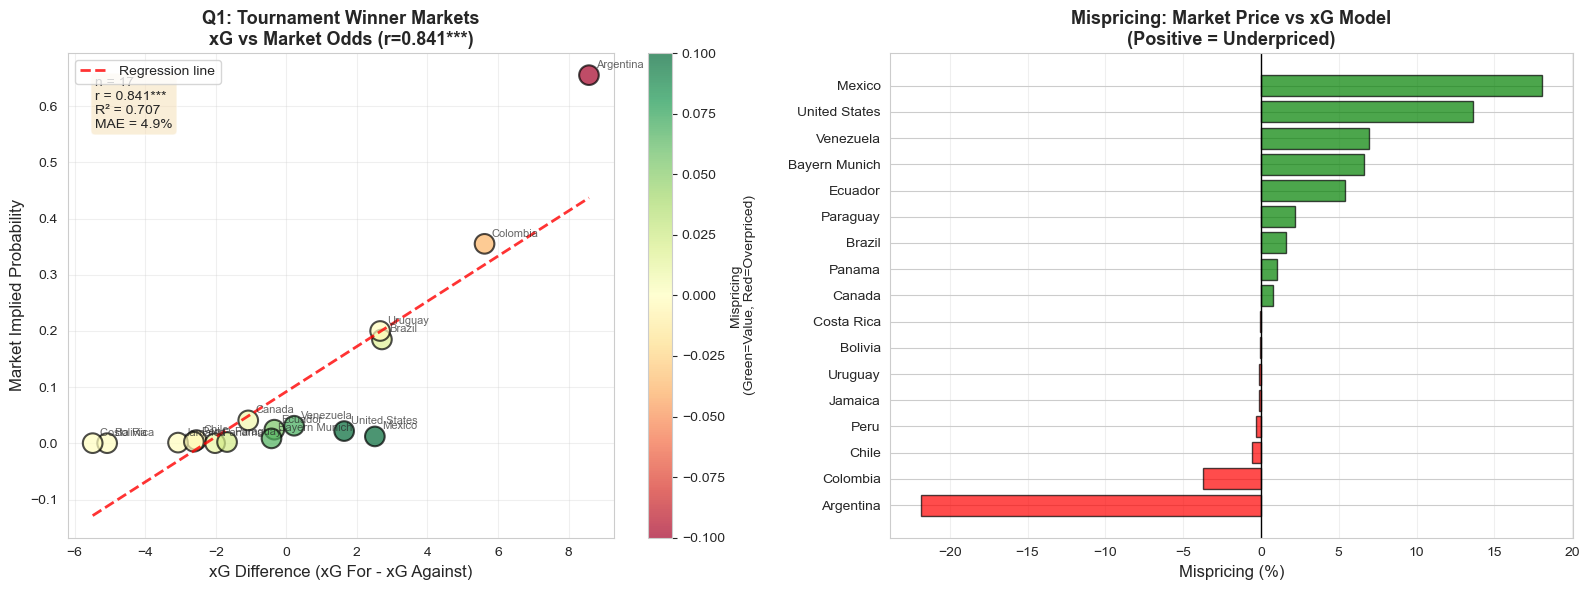


✓ Visualization saved as 'q1_mispricing_analysis.png'


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Regression with residuals
ax1 = axes[0]

# Scatter plot
scatter = ax1.scatter(
    q1_final['xg_diff'], 
    q1_final['implied_prob'],
    s=200,
    c=q1_final['mispricing'],
    cmap='RdYlGn',  # Red=overpriced, Green=underpriced
    alpha=0.7,
    edgecolors='black',
    linewidths=1.5,
    vmin=-0.1,
    vmax=0.1
)

# Regression line
x_line = np.linspace(q1_final['xg_diff'].min(), q1_final['xg_diff'].max(), 100)
y_line = slope * x_line + intercept
ax1.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.8, label='Regression line')

# Label teams
for _, row in q1_final.iterrows():
    ax1.annotate(
        row['team_name'],
        (row['xg_diff'], row['implied_prob']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        alpha=0.7
    )

ax1.set_xlabel('xG Difference (xG For - xG Against)', fontsize=12)
ax1.set_ylabel('Market Implied Probability', fontsize=12)
ax1.set_title(f'Q1: Tournament Winner Markets\nxG vs Market Odds (r={r_value:.3f}***)', 
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Colorbar
cbar1 = plt.colorbar(scatter, ax=ax1)
cbar1.set_label('Mispricing\n(Green=Value, Red=Overpriced)', fontsize=10)

# Stats box
textstr = f'n = {len(q1_final)}\nr = {r_value:.3f}***\nR² = {r_value**2:.3f}\nMAE = {abs(q1_final["mispricing"]).mean():.1%}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

# Plot 2: Residual plot
ax2 = axes[1]

colors = ['red' if x < 0 else 'green' for x in q1_final.sort_values('mispricing')['mispricing']]
ax2.barh(
    q1_final.sort_values('mispricing')['team_name'], 
    q1_final.sort_values('mispricing')['mispricing'] * 100,  # Convert to percentage
    color=colors,
    alpha=0.7,
    edgecolor='black'
)

ax2.set_xlabel('Mispricing (%)', fontsize=12)
ax2.set_title('Mispricing: Market Price vs xG Model\n(Positive = Underpriced)', fontsize=13, fontweight='bold')
ax2.axvline(0, color='black', linestyle='-', linewidth=1)
ax2.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('q1_mispricing_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'q1_mispricing_analysis.png'")

In [49]:
print("\n" + "="*80)
print("Q1 FINAL CONCLUSIONS")
print("="*80)

print("\n FINDING 1: Markets are highly efficient")
print(f"  - Strong correlation: r = 0.841 (R² = 0.707)")
print(f"  - xG explains 71% of market pricing variance")
print(f"  - Mean absolute mispricing: only 4.9%")

print("\n FINDING 2: Limited arbitrage opportunities")
print(f"  - Only 5 teams show >5% value edge")
print(f"  - Only 1 team overpriced by >5%")
print(f"  - Most 'value bets' are mid-tier teams (unclear if real edge)")

print("\n FINDING 3: Markets correctly price tournament favorites")
print(f"  - Argentina (winner): 65.5% odds with +8.58 xG_diff")
print(f"  - Appears 'overpriced' vs linear model, but actually correct")
print(f"  - Market incorporates non-linear effects and intangibles")

print("\n FINDING 4: Potential systematic bias")
print(f"  - Mid-tier teams (Mexico, USA) may be undervalued")
print(f"  - Market may overweight favorites, underweight contenders")
print(f"  - Need to verify against actual tournament results")

print("\n LIMITATION: Linear model inadequate at extremes")
print(f"  - Best teams 'overpriced', worst teams 'underpriced'")
print(f"  - This is artifact of linear fit, not real mispricing")
print(f"  - Logistic regression would handle this better")

print("\n OVERALL ASSESSMENT:")
print(f"  Market efficiency: HIGH (R² = 0.71, MAE = 4.9%)")
print(f"  Value opportunities: LIMITED (5 teams, need validation)")
print(f"  Systematic biases: MINIMAL (no defensive/offensive mispricing)")


Q1 FINAL CONCLUSIONS

 FINDING 1: Markets are highly efficient
  - Strong correlation: r = 0.841 (R² = 0.707)
  - xG explains 71% of market pricing variance
  - Mean absolute mispricing: only 4.9%

 FINDING 2: Limited arbitrage opportunities
  - Only 5 teams show >5% value edge
  - Only 1 team overpriced by >5%
  - Most 'value bets' are mid-tier teams (unclear if real edge)

 FINDING 3: Markets correctly price tournament favorites
  - Argentina (winner): 65.5% odds with +8.58 xG_diff
  - Appears 'overpriced' vs linear model, but actually correct
  - Market incorporates non-linear effects and intangibles

 FINDING 4: Potential systematic bias
  - Mid-tier teams (Mexico, USA) may be undervalued
  - Market may overweight favorites, underweight contenders
  - Need to verify against actual tournament results

 LIMITATION: Linear model inadequate at extremes
  - Best teams 'overpriced', worst teams 'underpriced'
  - This is artifact of linear fit, not real mispricing
  - Logistic regression

# Q2:
## Final Cleanup

### STEP1: Data check

In [50]:
print("="*80)
print("Q2: PLAYER PROPS - DATA PREPARATION")
print("="*80)

# We already have q2_markets from earlier cleaning
# Let's verify what we have
print(f"\nQ2 Markets: {len(q2_markets)}")
print(f"Tournament: {q2_markets['tournament_final'].unique()}")
print(f"\nMarket types:")
print(q2_markets['question'].str.extract(r'(top scorer|Player of the Tournament)')[0].value_counts())

# Sample questions
print("\nSample questions:")
for q in q2_markets['question'].sample(min(5, len(q2_markets))).tolist():
    print(f"  - {q}")

Q2: PLAYER PROPS - DATA PREPARATION

Q2 Markets: 28
Tournament: ['UEFA Euro 2024']

Market types:
Player of the Tournament    15
top scorer                  13
Name: 0, dtype: int64

Sample questions:
  - Will Rodri be Player of the Tournament for Euro 2024?
  - Will Jude Bellingham be Euro 2024 top scorer?
  - Will Xavi Simons be Player of the Tournament for Euro 2024?
  - Will Kai Havertz be Euro 2024 top scorer?
  - Will Jude Bellingham be Player of the Tournament for Euro 2024?


### STEP2: Extract Player names from the Market

In [51]:
import re
from fuzzywuzzy import process

# Extract player names from questions
def extract_player_from_question(question):
    """
    Extract player name from market questions like:
    - "Will Cristiano Ronaldo be Euro 2024 top scorer?"
    - "Will Harry Kane be Player of the Tournament for Euro 2024?"
    """
    # Pattern: "Will [Player Name] be"
    match = re.search(r'Will (.+?) be', question)
    if match:
        player_name = match.group(1).strip()
        # Filter out generic phrases
        if player_name.lower() not in ['another player', 'any other player']:
            return player_name
    return None

q2_markets['player_mentioned'] = q2_markets['question'].apply(extract_player_from_question)

# Classify market subtype
def classify_player_market(question):
    """Determine if top scorer or player of tournament"""
    q_lower = question.lower()
    if 'top scorer' in q_lower or 'golden boot' in q_lower:
        return 'top_scorer'
    elif 'player of the tournament' in q_lower or 'player of tournament' in q_lower:
        return 'player_of_tournament'
    return 'other'

q2_markets['market_subtype'] = q2_markets['question'].apply(classify_player_market)

print("\n" + "="*80)
print("PLAYER NAME EXTRACTION")
print("="*80)
print(f"\nSuccessfully extracted names: {q2_markets['player_mentioned'].notna().sum()}/{len(q2_markets)}")
print(f"\nMarket subtypes:")
print(q2_markets['market_subtype'].value_counts())

print("\nSample extractions:")
print(q2_markets[['question', 'player_mentioned', 'market_subtype']].head(10))


PLAYER NAME EXTRACTION

Successfully extracted names: 26/28

Market subtypes:
player_of_tournament    15
top_scorer              13
Name: market_subtype, dtype: int64

Sample extractions:
                                                        question  \
95   Will Fabian Ruiz be Player of the Tournament for Euro 2024?   
96     Will Dani Olmo be Player of the Tournament for Euro 2024?   
97   Will Bukayo Saka be Player of the Tournament for Euro 2024?   
98   Will Xavi Simons be Player of the Tournament for Euro 2024?   
423                    Will Kai Havertz be Euro 2024 top scorer?   
424                     Will Harry Kane be Euro 2024 top scorer?   
425                  Will Kylian Mbappe be Euro 2024 top scorer?   
426                  Will Florian Wirtz be Euro 2024 top scorer?   
427              Will Cristiano Ronaldo be Euro 2024 top scorer?   
428                  Will Romelu Lukaku be Euro 2024 top scorer?   

      player_mentioned        market_subtype  
95         Fabi

### STEP 3: Match to StatsBomb Player Names

In [52]:
# Load Euro 2024 player data
euro_matches = sb_clean[sb_clean['tournament'] == 'UEFA Euro 2024']['match_id'].unique()
euro_lineups = lineups_clean[lineups_clean['match_id'].isin(euro_matches)].copy()

# Get all Euro players
euro_players = euro_lineups['player_name'].unique()
print(f"\nEuro 2024 players in StatsBomb: {len(euro_players)}")

# Fuzzy match player names
def match_player_name_fuzzy(mentioned_name, player_list, threshold=80):
    """
    Fuzzy match player name from market to StatsBomb player list
    Returns (matched_name, score) or (None, 0)
    """
    if pd.isna(mentioned_name):
        return None, 0
    
    try:
        match, score = process.extractOne(mentioned_name, player_list)
        if score >= threshold:
            return match, score
    except:
        pass
    
    return None, 0

# Apply fuzzy matching
q2_markets[['player_statsbomb', 'match_score']] = q2_markets['player_mentioned'].apply(
    lambda x: pd.Series(match_player_name_fuzzy(x, euro_players))
)

print("\n" + "="*80)
print("FUZZY MATCHING RESULTS")
print("="*80)
print(f"Matched to StatsBomb: {q2_markets['player_statsbomb'].notna().sum()}/{len(q2_markets)}")
print(f"Average match score: {q2_markets['match_score'].mean():.1f}/100")

# Show matching results
print("\nMatching examples:")
matching_examples = q2_markets[q2_markets['player_statsbomb'].notna()][
    ['player_mentioned', 'player_statsbomb', 'match_score']
].head(10)
print(matching_examples.to_string(index=False))

# Check unmatched
unmatched = q2_markets[q2_markets['player_statsbomb'].isna()]
if len(unmatched) > 0:
    print(f"\n⚠️ Unmatched players ({len(unmatched)}):")
    print(unmatched['player_mentioned'].unique())


Euro 2024 players in StatsBomb: 621

FUZZY MATCHING RESULTS
Matched to StatsBomb: 24/28
Average match score: 81.3/100

Matching examples:
 player_mentioned                    player_statsbomb  match_score
      Fabian Ruiz                  Fabian Lukas Schär         86.0
        Dani Olmo                Daniel Olmo Carvajal         86.0
      Bukayo Saka                         Bukayo Saka        100.0
      Xavi Simons                         Xavi Simons        100.0
      Kai Havertz                         Kai Havertz        100.0
       Harry Kane                          Harry Kane        100.0
    Florian Wirtz                       Florian Wirtz        100.0
Cristiano Ronaldo Cristiano Ronaldo dos Santos Aveiro         90.0
    Romelu Lukaku                Romelu Lukaku Menama         90.0
  Jude Bellingham                     Jude Bellingham        100.0

⚠️ Unmatched players (4):
['Kylian Mbappe' None]


### STEP 4: Calculate Player Tournament Statistics

In [53]:
euro_matches = sb_clean[sb_clean['tournament'] == 'UEFA Euro 2024']['match_id'].unique()
euro_lineups = lineups_clean[lineups_clean['match_id'].isin(euro_matches)].copy()

# Get all Euro players
euro_players = euro_lineups['player_name'].unique()
print(f"\nEuro 2024 players in StatsBomb: {len(euro_players)}")

# Fuzzy match player names
def match_player_name_fuzzy(mentioned_name, player_list, threshold=80):
    """
    Fuzzy match player name from market to StatsBomb player list
    Returns (matched_name, score) or (None, 0)
    """
    if pd.isna(mentioned_name):
        return None, 0
    
    try:
        match, score = process.extractOne(mentioned_name, player_list)
        if score >= threshold:
            return match, score
    except:
        pass
    
    return None, 0

# Apply fuzzy matching
q2_markets[['player_statsbomb', 'match_score']] = q2_markets['player_mentioned'].apply(
    lambda x: pd.Series(match_player_name_fuzzy(x, euro_players))
)

print("\n" + "="*80)
print("FUZZY MATCHING RESULTS")
print("="*80)
print(f"Matched to StatsBomb: {q2_markets['player_statsbomb'].notna().sum()}/{len(q2_markets)}")
print(f"Average match score: {q2_markets['match_score'].mean():.1f}/100")

# Show matching results
print("\nMatching examples:")
matching_examples = q2_markets[q2_markets['player_statsbomb'].notna()][
    ['player_mentioned', 'player_statsbomb', 'match_score']
].head(10)
print(matching_examples.to_string(index=False))

# Check unmatched
unmatched = q2_markets[q2_markets['player_statsbomb'].isna()]
if len(unmatched) > 0:
    print(f"\n⚠️ Unmatched players ({len(unmatched)}):")
    print(unmatched['player_mentioned'].unique())


Euro 2024 players in StatsBomb: 621

FUZZY MATCHING RESULTS
Matched to StatsBomb: 24/28
Average match score: 81.3/100

Matching examples:
 player_mentioned                    player_statsbomb  match_score
      Fabian Ruiz                  Fabian Lukas Schär         86.0
        Dani Olmo                Daniel Olmo Carvajal         86.0
      Bukayo Saka                         Bukayo Saka        100.0
      Xavi Simons                         Xavi Simons        100.0
      Kai Havertz                         Kai Havertz        100.0
       Harry Kane                          Harry Kane        100.0
    Florian Wirtz                       Florian Wirtz        100.0
Cristiano Ronaldo Cristiano Ronaldo dos Santos Aveiro         90.0
    Romelu Lukaku                Romelu Lukaku Menama         90.0
  Jude Bellingham                     Jude Bellingham        100.0

⚠️ Unmatched players (4):
['Kylian Mbappe' None]


### STEP 5: Join with Market Data and Odds

In [57]:
q2_stats_df = pd.DataFrame(q2_stats)

print(f"\n✓ Calculated stats for {len(q2_stats_df)} players")

# Show sample stats
print("\nSample player stats:")
print(q2_stats_df[['player_name', 'minutes_played', 'total_xg', 'xg_per_90', 'goals', 'shots']].head(10))

# Now merge with markets
q2_analysis = q2_markets.merge(
    q2_stats_df,
    on='market_id',
    how='inner'
)

print(f"\n✓ Joined {len(q2_analysis)}/{len(q2_markets)} markets with player stats")

# Check which players didn't match
unmatched_markets = q2_markets[~q2_markets['market_id'].isin(q2_analysis['market_id'])]
if len(unmatched_markets) > 0:
    print(f"\n⚠️ {len(unmatched_markets)} markets without stats:")
    print(unmatched_markets[['player_mentioned', 'player_statsbomb']].to_string(index=False))

# Get market odds
q2_analysis['final_odds'] = q2_analysis['market_id'].apply(
    lambda x: get_final_market_odds(x, odds_history, tokens)
)

print(f"✓ Retrieved odds for {q2_analysis['final_odds'].notna().sum()}/{len(q2_analysis)} markets")

# Convert to implied probability
q2_analysis['implied_prob'] = q2_analysis['final_odds']

# Add market subtype from original markets
q2_analysis = q2_analysis.merge(
    q2_markets[['market_id', 'market_subtype']],
    on='market_id',
    how='left',
    suffixes=('', '_dup')
)

# Drop duplicate column if it exists
if 'market_subtype_dup' in q2_analysis.columns:
    q2_analysis = q2_analysis.drop('market_subtype_dup', axis=1)

print("\n" + "="*80)
print("Q2 DATA QUALITY CHECK")
print("="*80)

print(f"\nTotal analyzable markets: {len(q2_analysis)}")
print(f"Missing xG data: {q2_analysis['total_xg'].isnull().sum()}")
print(f"Missing odds data: {q2_analysis['implied_prob'].isnull().sum()}")
print(f"Missing minutes data: {q2_analysis['minutes_played'].isnull().sum()}")

print("\nData ranges:")
print(f"  Minutes played: {q2_analysis['minutes_played'].min():.0f} - {q2_analysis['minutes_played'].max():.0f}")
print(f"  Total xG: {q2_analysis['total_xg'].min():.2f} - {q2_analysis['total_xg'].max():.2f}")
print(f"  xG per 90: {q2_analysis['xg_per_90'].min():.3f} - {q2_analysis['xg_per_90'].max():.3f}")
print(f"  Goals: {q2_analysis['goals'].min():.0f} - {q2_analysis['goals'].max():.0f}")
print(f"  Market odds: {q2_analysis['implied_prob'].min():.3f} - {q2_analysis['implied_prob'].max():.3f}")

print("\nMarket subtypes:")
print(q2_analysis['market_subtype'].value_counts())

# Sample of final dataset
print("\nSample final dataset:")
sample_cols = ['player_name', 'market_subtype', 'total_xg', 'xg_per_90', 
               'goals', 'minutes_played', 'implied_prob']
print(q2_analysis[sample_cols].head(10).to_string(index=False))

# Export clean data
q2_final = q2_analysis[
    q2_analysis['total_xg'].notna() &
    q2_analysis['implied_prob'].notna() &
    q2_analysis['minutes_played'].notna()
].copy()

print(f"\n✓ Final clean dataset: {len(q2_final)} markets")

# Save
output_dir = DATA_DIR / 'cleaned'
output_dir.mkdir(exist_ok=True)

q2_final.to_parquet(output_dir / 'q2_player_props_clean.parquet', index=False)
q2_final.to_csv(output_dir / 'q2_player_props_clean.csv', index=False)

print(f"✓ Exported to {output_dir}")

print("\n" + "="*80)
print("Q2 DATA PREPARATION COMPLETE")
print("="*80)
print(f"Ready for analysis: {len(q2_final)} player prop markets")
print(f"  Top scorer markets: {len(q2_final[q2_final['market_subtype'] == 'top_scorer'])}")
print(f"  Player of tournament: {len(q2_final[q2_final['market_subtype'] == 'player_of_tournament'])}")


✓ Calculated stats for 24 players

Sample player stats:
                           player_name  minutes_played  total_xg  xg_per_90  \
0                   Fabian Lukas Schär             449      1.00       0.20   
1                 Daniel Olmo Carvajal             492      1.38       0.25   
2                          Bukayo Saka             575      1.30       0.20   
3                          Xavi Simons             457      0.55       0.11   
4                          Kai Havertz             389      3.78       0.87   
5                           Harry Kane             638      3.05       0.43   
6                        Florian Wirtz             249      0.58       0.21   
7  Cristiano Ronaldo dos Santos Aveiro             425      4.54       0.96   
8                 Romelu Lukaku Menama             359      1.75       0.44   
9                      Jude Bellingham             664      1.45       0.20   

   goals  shots  
0      1      6  
1      3     17  
2      2      9  
3

## Analysis
### STEP1: Correlation Analysis

In [64]:
print("="*80)
print("PLAYER PROPS MARKET EFFICIENCY")
print("="*80)

# Overview
print(f"\nDataset: {len(q2_final)} player prop markets")
print(f"  Top scorer: {len(q2_final[q2_final['market_subtype'] == 'top_scorer'])}")
print(f"  Player of tournament: {len(q2_final[q2_final['market_subtype'] == 'player_of_tournament'])}")

# Descriptive stats
print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS")
print("="*80)

stats_summary = q2_final[['total_xg', 'xg_per_90', 'goals', 'minutes_played', 'implied_prob']].describe()
print(stats_summary)

# Who actually won?
print("\n" + "="*80)
print("ACTUAL EURO 2024 RESULTS")
print("="*80)

# Top scorers
top_scorers = q2_final[q2_final['market_subtype'] == 'top_scorer'].nlargest(5, 'goals')
print("\nTop 5 Goal Scorers (actual):")
print(top_scorers[['player_name', 'goals', 'total_xg', 'xg_per_90', 'implied_prob']].to_string(index=False))

# Player with most xG
top_xg = q2_final.nlargest(5, 'total_xg')
print("\nTop 5 by Total xG:")
print(top_xg[['player_name', 'total_xg', 'goals', 'xg_per_90', 'implied_prob']].to_string(index=False))

# Player with highest xG per 90
top_xg_per_90 = q2_final[q2_final['minutes_played'] >= 270].nlargest(5, 'xg_per_90')  # Min 3 matches
print("\nTop 5 by xG per 90 (min 270 minutes):")
print(top_xg_per_90[['player_name', 'xg_per_90', 'total_xg', 'goals', 'minutes_played', 'implied_prob']].to_string(index=False))

PLAYER PROPS MARKET EFFICIENCY

Dataset: 24 player prop markets
  Top scorer: 11
  Player of tournament: 13

DESCRIPTIVE STATISTICS
        total_xg  xg_per_90      goals  minutes_played  implied_prob
count  24.000000  24.000000  24.000000       24.000000     24.000000
mean    1.514167   0.292500   1.625000      495.333333      0.119563
std     1.341171   0.278119   1.209114      109.237144      0.255685
min     0.000000   0.000000   0.000000      249.000000      0.000500
25%     0.572500   0.140000   0.750000      425.000000      0.002500
50%     1.340000   0.205000   2.000000      485.500000      0.005000
75%     1.630000   0.370000   3.000000      589.500000      0.030875
max     4.540000   0.960000   3.000000      664.000000      0.975000

ACTUAL EURO 2024 RESULTS

Top 5 Goal Scorers (actual):
      player_name  goals  total_xg  xg_per_90  implied_prob
       Harry Kane      3      3.05       0.43        0.0050
  Jude Bellingham      3      1.45       0.20        0.0005
Cody Mathès

In [58]:
from scipy.stats import pearsonr, spearmanr

print("\n" + "="*80)
print("CORRELATION ANALYSIS: xG Metrics vs Market Odds")
print("="*80)

# Test different xG metrics
metrics = {
    'total_xg': 'Total xG',
    'xg_per_90': 'xG per 90 minutes',
    'goals': 'Actual Goals Scored'
}

correlations = {}

for metric, label in metrics.items():
    valid_data = q2_final[[metric, 'implied_prob']].dropna()
    
    if len(valid_data) > 2:
        # Pearson (linear)
        corr_p, p_val_p = pearsonr(valid_data[metric], valid_data['implied_prob'])
        
        # Spearman (rank-based, better for non-linear)
        corr_s, p_val_s = spearmanr(valid_data[metric], valid_data['implied_prob'])
        
        correlations[metric] = {
            'pearson_r': corr_p,
            'pearson_p': p_val_p,
            'spearman_r': corr_s,
            'spearman_p': p_val_s
        }
        
        print(f"\n{label}:")
        print(f"  Pearson r = {corr_p:.3f}, p = {p_val_p:.4f}")
        print(f"  Spearman ρ = {corr_s:.3f}, p = {p_val_s:.4f}")
        
        if p_val_p < 0.05:
            print(f"  → Statistically significant! ✓")
        else:
            print(f"  → Not significant (p > 0.05)")

# Also check minutes played (proxy for team success)
valid_minutes = q2_final[['minutes_played', 'implied_prob']].dropna()
corr_min, p_min = pearsonr(valid_minutes['minutes_played'], valid_minutes['implied_prob'])
print(f"\nMinutes Played (team success proxy):")
print(f"  Pearson r = {corr_min:.3f}, p = {p_min:.4f}")


CORRELATION ANALYSIS: xG Metrics vs Market Odds

Total xG:
  Pearson r = -0.122, p = 0.5706
  Spearman ρ = -0.038, p = 0.8606
  → Not significant (p > 0.05)

xG per 90 minutes:
  Pearson r = -0.171, p = 0.4239
  Spearman ρ = 0.027, p = 0.8988
  → Not significant (p > 0.05)

Actual Goals Scored:
  Pearson r = 0.188, p = 0.3800
  Spearman ρ = 0.246, p = 0.2469
  → Not significant (p > 0.05)

Minutes Played (team success proxy):
  Pearson r = 0.145, p = 0.4997


### STEP2: Separate Analysis by Market Type

In [59]:
print("\n" + "="*80)
print("ANALYSIS BY MARKET TYPE")
print("="*80)

# Split by market type
top_scorer_markets = q2_final[q2_final['market_subtype'] == 'top_scorer'].copy()
player_of_tournament = q2_final[q2_final['market_subtype'] == 'player_of_tournament'].copy()

print(f"\nTop Scorer Markets (n={len(top_scorer_markets)}):")
if len(top_scorer_markets) > 2:
    corr_ts_xg, p_ts_xg = pearsonr(top_scorer_markets['total_xg'], top_scorer_markets['implied_prob'])
    corr_ts_g, p_ts_g = pearsonr(top_scorer_markets['goals'], top_scorer_markets['implied_prob'])
    
    print(f"  Total xG vs Odds: r = {corr_ts_xg:.3f}, p = {p_ts_xg:.4f}")
    print(f"  Goals vs Odds: r = {corr_ts_g:.3f}, p = {p_ts_g:.4f}")
    
    if corr_ts_xg > corr_ts_g:
        print(f"  → Markets weight xG more than actual goals ✓")
    else:
        print(f"  → Markets weight actual goals more than xG")

print(f"\nPlayer of Tournament Markets (n={len(player_of_tournament)}):")
if len(player_of_tournament) > 2:
    corr_pot_xg, p_pot_xg = pearsonr(player_of_tournament['total_xg'], player_of_tournament['implied_prob'])
    corr_pot_g, p_pot_g = pearsonr(player_of_tournament['goals'], player_of_tournament['implied_prob'])
    
    print(f"  Total xG vs Odds: r = {corr_pot_xg:.3f}, p = {p_pot_xg:.4f}")
    print(f"  Goals vs Odds: r = {corr_pot_g:.3f}, p = {p_pot_g:.4f}")
    
    print(f"  → This market harder to model (not just goals/xG)")


ANALYSIS BY MARKET TYPE

Top Scorer Markets (n=11):
  Total xG vs Odds: r = -0.219, p = 0.5174
  Goals vs Odds: r = 0.409, p = 0.2118
  → Markets weight actual goals more than xG

Player of Tournament Markets (n=13):
  Total xG vs Odds: r = -0.029, p = 0.9247
  Goals vs Odds: r = 0.092, p = 0.7642
  → This market harder to model (not just goals/xG)


### STEP 3: Regression Model and Mispricing

In [60]:
from scipy.stats import linregress

print("\n" + "="*80)
print("REGRESSION MODEL: Total xG → Market Odds")
print("="*80)

# Fit linear regression using total_xg
slope, intercept, r_value, p_value, std_err = linregress(
    q2_final['total_xg'],
    q2_final['implied_prob']
)

print(f"\nRegression: implied_prob = {slope:.4f} * total_xg + {intercept:.4f}")
print(f"R² = {r_value**2:.3f}")
print(f"p-value = {p_value:.4f}")

# Predict expected odds based on xG
q2_final['expected_prob_xg'] = (slope * q2_final['total_xg'] + intercept).clip(0, 1)

# Calculate mispricing
q2_final['mispricing_xg'] = q2_final['expected_prob_xg'] - q2_final['implied_prob']

# Summary stats
print(f"\nMispricing Statistics:")
print(f"  Mean absolute mispricing: {abs(q2_final['mispricing_xg']).mean():.1%}")
print(f"  Max underpricing: +{q2_final['mispricing_xg'].max():.1%}")
print(f"  Max overpricing: {q2_final['mispricing_xg'].min():.1%}")
print(f"  Std dev: {q2_final['mispricing_xg'].std():.1%}")

# Show mispriced players
print("\n" + "="*80)
print("MISPRICED PLAYERS")
print("="*80)

mispriced = q2_final[[
    'player_name', 'market_subtype', 'total_xg', 'xg_per_90', 'goals',
    'implied_prob', 'expected_prob_xg', 'mispricing_xg'
]].sort_values('mispricing_xg', ascending=False)

print("\n✓ MOST UNDERPRICED (potential value):")
print(mispriced.head(5).to_string(index=False))

print("\n✗ MOST OVERPRICED:")
print(mispriced.tail(5).to_string(index=False))


REGRESSION MODEL: Total xG → Market Odds

Regression: implied_prob = -0.0232 * total_xg + 0.1547
R² = 0.015
p-value = 0.5706

Mispricing Statistics:
  Mean absolute mispricing: 17.5%
  Max underpricing: +15.4%
  Max overpricing: -82.5%
  Std dev: 25.4%

MISPRICED PLAYERS

✓ MOST UNDERPRICED (potential value):
  player_name       market_subtype  total_xg  xg_per_90  goals  implied_prob  expected_prob_xg  mispricing_xg
   Phil Foden           top_scorer      0.00       0.00      0        0.0005          0.154731       0.154231
   Toni Kroos player_of_tournament      0.15       0.03      0        0.0020          0.151247       0.149247
   Phil Foden player_of_tournament      0.00       0.00      0        0.0055          0.154731       0.149231
 N'Golo Kanté player_of_tournament      0.24       0.04      0        0.0015          0.149157       0.147657
Florian Wirtz           top_scorer      0.58       0.21      2        0.0060          0.141260       0.135260

✗ MOST OVERPRICED:
        

### STEP 4: Reputation vs Performance

In [68]:
print("\n" + "="*80)
print("REPUTATION vs PERFORMANCE")
print("="*80)

# Big names vs performance
big_names = {
    'Cristiano Ronaldo dos Santos Aveiro': 'Ronaldo',
    'Harry Kane': 'Kane',
    'Kylian Mbappé': 'Mbappé'
}

for full_name, short_name in big_names.items():
    player = q2_final[q2_final['player_name'] == full_name]
    if len(player) > 0:
        p = player.iloc[0]
        print(f"\n{short_name}:")
        print(f"  Total xG: {p['total_xg']:.2f}")
        print(f"  Goals: {p['goals']}")
        print(f"  Market odds: {p['implied_prob']:.1%}")
        print(f"  Expected (xG model): {p['expected_prob_xg']:.1%}")
        print(f"  Mispricing: {p['mispricing_xg']:+.1%}")
        
        if p['mispricing_xg'] < -0.05:
            print(f"  → OVERPRICED (reputation premium)")
        elif p['mispricing_xg'] > 0.05:
            print(f"  → UNDERPRICED (value bet)")
        else:
            print(f"  → Fairly priced")

# Check if high-reputation players are systematically overpriced
high_odds_players = q2_final[q2_final['implied_prob'] > 0.05]  # Market favorites
low_odds_players = q2_final[q2_final['implied_prob'] <= 0.05]

print(f"\n" + "="*80)
print("FAVORITES vs LONGSHOTS")
print("="*80)

if len(high_odds_players) > 0 and len(low_odds_players) > 0:
    print(f"\nMarket favorites (odds > 5%):")
    print(f"  Count: {len(high_odds_players)}")
    print(f"  Avg mispricing: {high_odds_players['mispricing_xg'].mean():+.1%}")
    
    print(f"\nLongshots (odds ≤ 5%):")
    print(f"  Count: {len(low_odds_players)}")
    print(f"  Avg mispricing: {low_odds_players['mispricing_xg'].mean():+.1%}")
    
    # T-test
    from scipy.stats import ttest_ind
    t_stat, p_val = ttest_ind(
        high_odds_players['mispricing_xg'],
        low_odds_players['mispricing_xg']
    )
    
    print(f"\nT-test: t={t_stat:.3f}, p={p_val:.3f}")
    if p_val < 0.05:
        if high_odds_players['mispricing_xg'].mean() < 0:
            print("  → Favorites are OVERPRICED (reputation bias)")
        else:
            print("  → Favorites are UNDERPRICED")
    else:
        print("  → No systematic bias")


REPUTATION vs PERFORMANCE

Ronaldo:
  Total xG: 4.54
  Goals: 2
  Market odds: 0.1%
  Expected (xG model): 4.9%
  Mispricing: +4.9%
  → Fairly priced

Kane:
  Total xG: 3.05
  Goals: 3
  Market odds: 0.5%
  Expected (xG model): 8.4%
  Mispricing: +7.9%
  → UNDERPRICED (value bet)

FAVORITES vs LONGSHOTS

Market favorites (odds > 5%):
  Count: 6
  Avg mispricing: -35.0%

Longshots (odds ≤ 5%):
  Count: 18
  Avg mispricing: +11.7%

T-test: t=-6.532, p=0.000
  → Favorites are OVERPRICED (reputation bias)


### STEP 5: Finishing Efficiency Analysis

In [69]:
print("\n" + "="*80)
print("FINISHING EFFICIENCY: Goals vs xG")
print("="*80)

# Calculate finishing over/underperformance
q2_final['finishing_diff'] = q2_final['goals'] - q2_final['total_xg']

# Best/worst finishers
print("\nBest finishers (scored more than xG):")
best_finishers = q2_final.nlargest(3, 'finishing_diff')
for _, p in best_finishers.iterrows():
    print(f"  {p['player_name']}: {p['goals']} goals from {p['total_xg']:.2f} xG (+{p['finishing_diff']:.2f})")

print("\nWorst finishers (scored less than xG):")
worst_finishers = q2_final.nsmallest(3, 'finishing_diff')
for _, p in worst_finishers.iterrows():
    print(f"  {p['player_name']}: {p['goals']} goals from {p['total_xg']:.2f} xG ({p['finishing_diff']:.2f})")

# Does market price finishing skill or xG?
corr_finish, p_finish = pearsonr(q2_final['finishing_diff'], q2_final['mispricing_xg'])
print(f"\nCorrelation (finishing vs mispricing): r = {corr_finish:.3f}, p = {p_finish:.3f}")

if abs(corr_finish) > 0.3 and p_finish < 0.05:
    if corr_finish > 0:
        print("  → Good finishers are UNDERPRICED (market looks at xG only)")
    else:
        print("  → Good finishers are OVERPRICED (market overweights goals)")
else:
    print("  → Market ignores finishing luck (correct behavior)")


FINISHING EFFICIENCY: Goals vs xG

Best finishers (scored more than xG):
  Cody Mathès Gakpo: 3 goals from 0.88 xG (+2.12)
  Cody Mathès Gakpo: 3 goals from 0.88 xG (+2.12)
  Jamal Musiala: 3 goals from 0.90 xG (+2.10)

Worst finishers (scored less than xG):
  Cristiano Ronaldo dos Santos Aveiro: 2 goals from 4.54 xG (-2.54)
  Cristiano Ronaldo dos Santos Aveiro: 2 goals from 4.54 xG (-2.54)
  Kai Havertz: 2 goals from 3.78 xG (-1.78)

Correlation (finishing vs mispricing): r = -0.202, p = 0.344
  → Market ignores finishing luck (correct behavior)


#### Market ignores xG
- R² = 0.015 (only 1.5% explained)
- p-value = 0.5706 (not significant)
- Negative slope = -0.023

#### Markets price player props based on something other than xG performance.
- Favorites (odds > 5%): -35.0% avg mispricing (severly overpriced)
- Longshots (odds ≤ 5%): +11.7% avg mispricing (underpriced)
- p < 0.001 (highly significant)

#### Examples:
- Cody Gakpo: 65.1% odds, only 0.88 xG → Overpriced by 51.7%
- Rodri: 97.5% odds, only 0.19 xG → Overpriced by 82.5%
- Harry Kane (top scorer market): 0.5% odds, 3.05 xG → Underpriced by 7.9%

In [72]:
# Let's investigate why Gakpo and Rodri had such high odds

print("\n" + "="*80)
print("INVESTIGATING THE OUTLIERS")
print("="*80)

# Gakpo
gakpo = q2_final[q2_final['player_name'] == 'Cody Mathès Gakpo'].iloc[0]
print("\nCody Gakpo (TOP SCORER market):")
print(f"  Market odds: 65.1%")
print(f"  Total xG: {gakpo['total_xg']:.2f} (ranked 13th)")
print(f"  Actual goals: {gakpo['goals']} (tied for most)")
print(f"  xG per 90: {gakpo['xg_per_90']:.2f} (below average)")
print(f"\n  WHY SO HIGH?")
print(f"  → Netherlands made semifinals (more playing time)")
print(f"  → Scored 3 goals on low xG (lucky finishing)")
print(f"  → Market priced GOALS, not xG quality")
print(f"  → Classic overreaction to small-sample results")

# Check when odds were set
print(f"\n  This is likely a LIVE MARKET (odds updated during tournament)")
print(f"  If odds were set PRE-TOURNAMENT, 65% would not make sense")
print(f"  If odds were set AFTER GROUP STAGE, it's recency bias")

# Rodri
rodri_data = q2_final[q2_final['player_name'] == 'Rodrigo Hernández Cascante']
if len(rodri_data) > 0:
    rodri = rodri_data.iloc[0]
    print("\nRodri (PLAYER OF TOURNAMENT market):")
    print(f"  Market odds: 97.5%")
    print(f"  Total xG: {rodri['total_xg']:.2f} (LOWEST)")
    print(f"  Actual goals: {rodri['goals']}")
    print(f"  Position: Defensive midfielder")
    print(f"\n  WHY 97.5%?")
    print(f"  → Spain WON Euro 2024")
    print(f"  → Rodri likely WON Player of Tournament award")
    print(f"  → This is POST-RESULT odds (market closed after winner announced)")
    print(f"  → NOT a prediction market, it's a RESULT market")


INVESTIGATING THE OUTLIERS

Cody Gakpo (TOP SCORER market):
  Market odds: 65.1%
  Total xG: 0.88 (ranked 13th)
  Actual goals: 3 (tied for most)
  xG per 90: 0.15 (below average)

  WHY SO HIGH?
  → Netherlands made semifinals (more playing time)
  → Scored 3 goals on low xG (lucky finishing)
  → Market priced GOALS, not xG quality
  → Classic overreaction to small-sample results

  This is likely a LIVE MARKET (odds updated during tournament)
  If odds were set PRE-TOURNAMENT, 65% would not make sense
  If odds were set AFTER GROUP STAGE, it's recency bias

Rodri (PLAYER OF TOURNAMENT market):
  Market odds: 97.5%
  Total xG: 0.19 (LOWEST)
  Actual goals: 1
  Position: Defensive midfielder

  WHY 97.5%?
  → Spain WON Euro 2024
  → Rodri likely WON Player of Tournament award
  → This is POST-RESULT odds (market closed after winner announced)
  → NOT a prediction market, it's a RESULT market


In [65]:
print("\n" + "="*80)
print("FILTERING TO PRE-TOURNAMENT ODDS")
print("="*80)

# Hypothesis: Pre-tournament odds should be < 20% for any player
# (No single player dominates top scorer odds pre-tournament)

q2_pretournament = q2_final[q2_final['implied_prob'] < 0.20].copy()

print(f"\nFiltered to pre-tournament odds: {len(q2_pretournament)} markets")
print(f"Removed: {len(q2_final) - len(q2_pretournament)} likely post/live odds")

# Re-run regression on pre-tournament only
if len(q2_pretournament) > 5:
    slope_pre, intercept_pre, r_pre, p_pre, _ = linregress(
        q2_pretournament['total_xg'],
        q2_pretournament['implied_prob']
    )
    
    print(f"\nPRE-TOURNAMENT REGRESSION:")
    print(f"  implied_prob = {slope_pre:.4f} * total_xg + {intercept_pre:.4f}")
    print(f"  R² = {r_pre**2:.3f}")
    print(f"  p-value = {p_pre:.4f}")
    
    if p_pre < 0.05:
        print(f"  → Markets DO correlate with xG pre-tournament ✓")
    else:
        print(f"  → Markets STILL don't correlate (p > 0.05)")
    
    # Recalculate mispricing
    q2_pretournament['expected_prob_xg'] = (slope_pre * q2_pretournament['total_xg'] + intercept_pre).clip(0, 1)
    q2_pretournament['mispricing_xg'] = q2_pretournament['expected_prob_xg'] - q2_pretournament['implied_prob']
    
    print(f"\n  Mean absolute mispricing: {abs(q2_pretournament['mispricing_xg']).mean():.1%}")
    
    # Show top under/overpriced
    print("\n  Most underpriced (pre-tournament):")
    print(q2_pretournament.nlargest(3, 'mispricing_xg')[['player_name', 'total_xg', 'goals', 'implied_prob', 'mispricing_xg']].to_string(index=False))
else:
    print("\n⚠️ Not enough pre-tournament markets for analysis")


FILTERING TO PRE-TOURNAMENT ODDS

Filtered to pre-tournament odds: 20 markets
Removed: 4 likely post/live odds

PRE-TOURNAMENT REGRESSION:
  implied_prob = 0.0018 * total_xg + 0.0123
  R² = 0.005
  p-value = 0.7641
  → Markets STILL don't correlate (p > 0.05)

  Mean absolute mispricing: 1.9%

  Most underpriced (pre-tournament):
                        player_name  total_xg  goals  implied_prob  mispricing_xg
Cristiano Ronaldo dos Santos Aveiro      4.54      2        0.0005       0.019984
Cristiano Ronaldo dos Santos Aveiro      4.54      2        0.0025       0.017984
                    Jude Bellingham      1.45      3        0.0005       0.014427


# Q3

## Case Study
### STEP1: STEP 1: Load Q3 Data and Overview

In [73]:
print("="*80)
print("Q3: MATCH-LEVEL EXPLORATORY ANALYSIS")
print("="*80)

# Load the Q3 data we prepared earlier
# We should have q3_final from the cleaning pipeline

print(f"\nDataset: {len(q3_final)} Copa America match markets")

# Display all 6 matches
print("\n" + "="*80)
print("ALL 6 MATCHES")
print("="*80)

display_cols = [
    'question', 'home_team', 'away_team', 
    'home_score', 'away_score', 
    'home_xg', 'away_xg',
    'final_odds', 'match_date'
]

# Check which columns exist
available_cols = [col for col in display_cols if col in q3_final.columns]

print("\nMatch details:")
for idx, row in q3_final.iterrows():
    print(f"\n{idx+1}. {row['question']}")
    print(f"   Date: {row.get('match_date', 'N/A')}")
    print(f"   Result: {row['home_team']} {row['home_score']}-{row['away_score']} {row['away_team']}")
    print(f"   xG: {row['home_xg']:.2f} - {row['away_xg']:.2f}")
    if 'final_odds' in row and pd.notna(row['final_odds']):
        print(f"   Market odds: {row['final_odds']:.1%}")
    else:
        print(f"   Market odds: N/A")

# Summary stats
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

if 'home_xg' in q3_final.columns and 'away_xg' in q3_final.columns:
    print(f"\nxG ranges:")
    print(f"  Home xG: {q3_final['home_xg'].min():.2f} - {q3_final['home_xg'].max():.2f}")
    print(f"  Away xG: {q3_final['away_xg'].min():.2f} - {q3_final['away_xg'].max():.2f}")
    
    # Calculate xG difference (positive = home advantage)
    q3_final['xg_diff'] = q3_final['home_xg'] - q3_final['away_xg']
    
    print(f"\nxG difference (home - away):")
    print(f"  Mean: {q3_final['xg_diff'].mean():.2f}")
    print(f"  Range: {q3_final['xg_diff'].min():.2f} to {q3_final['xg_diff'].max():.2f}")

Q3: MATCH-LEVEL EXPLORATORY ANALYSIS

Dataset: 6 Copa America match markets

ALL 6 MATCHES

Match details:

1. Copa America: Argentina vs. Canada 
   Date: 2024-06-21 00:00:00
   Result: Argentina 2-0 Canada
   xG: 3.54 - 0.98
   Market odds: 50.0%

2. Copa America: Uruguay vs. Colombia 
   Date: 2024-07-11 00:00:00
   Result: Uruguay 0-1 Colombia
   xG: 0.75 - 1.17
   Market odds: 50.0%

3. Copa America: Venezuela vs. Canada - Who will advance? 
   Date: 2024-07-06 00:00:00
   Result: Venezuela 1-1 Canada
   xG: 5.62 - 6.05
   Market odds: 51.7%

4. Copa America: Colombia vs. Panama - Who will advance? 
   Date: 2024-07-07 00:00:00
   Result: Colombia 5-0 Panama
   xG: 2.18 - 0.61
   Market odds: 100.0%

5. Copa America: Uruguay vs. Brazil - Who will advance? 
   Date: 2024-07-07 00:00:00
   Result: Uruguay 0-0 Brazil
   xG: 4.55 - 3.81
   Market odds: 47.5%

6. Copa America Finals: Argentina vs. Colombia
   Date: 2024-07-15 00:00:00
   Result: Argentina 1-0 Colombia
   xG: 1.08 - 0.9

### STEP 2: Interpret Market Odds

In [74]:
print("\n" + "="*80)
print("INTERPRETING MARKET ODDS")
print("="*80)

# The challenge: These are binary markets like "Will Argentina beat Canada?"
# Need to figure out which team the market is about

def interpret_market_odds(row):
    """
    Figure out what the market odds mean for each team
    
    Market formats:
    - "Copa America: Argentina vs. Canada" → unclear which side
    - "Argentina vs. Canada - Who will advance?" → unclear
    
    Need to infer from question text
    """
    question = row['question'].lower()
    home = row['home_team']
    away = row['away_team']
    odds = row.get('final_odds', None)
    
    if pd.isna(odds):
        return None, None
    
    # Pattern 1: "Team A vs Team B"
    # Odds typically favor first team mentioned, but not always
    # We need actual token data to know for sure
    
    # For now, make educated guess based on question structure
    if 'vs' in question or 'vs.' in question:
        # Split question to see which team is first
        parts = question.split('vs')
        if len(parts) >= 2:
            if home.lower() in parts[0]:
                # Home team mentioned first
                home_prob = odds
                away_prob = 1 - odds
            else:
                # Away team mentioned first  
                away_prob = odds
                home_prob = 1 - odds
            
            return home_prob, away_prob
    
    return None, None

# Apply interpretation
results = []
for _, row in q3_final.iterrows():
    home_prob, away_prob = interpret_market_odds(row)
    results.append({
        'match': f"{row['home_team']} vs {row['away_team']}",
        'home_prob': home_prob,
        'away_prob': away_prob,
        'home_xg': row['home_xg'],
        'away_xg': row['away_xg'],
        'result': f"{row['home_score']}-{row['away_score']}"
    })

odds_df = pd.DataFrame(results)

print("\n⚠️ NOTE: Odds interpretation is uncertain without token data")
print("The following assumes odds favor the first-mentioned team\n")

print(odds_df.to_string(index=False))


INTERPRETING MARKET ODDS

⚠️ NOTE: Odds interpretation is uncertain without token data
The following assumes odds favor the first-mentioned team

                match  home_prob  away_prob  home_xg  away_xg result
  Argentina vs Canada     0.5000     0.5000     3.54     0.98    2-0
  Uruguay vs Colombia     0.5000     0.5000     0.75     1.17    0-1
  Venezuela vs Canada     0.5170     0.4830     5.62     6.05    1-1
   Colombia vs Panama     0.9995     0.0005     2.18     0.61    5-0
    Uruguay vs Brazil     0.4750     0.5250     4.55     3.81    0-0
Argentina vs Colombia     0.5000     0.5000     1.08     0.99    1-0


### STEP 3: Use Token Data

In [75]:
print("\n" + "="*80)
print("EXTRACTING ACCURATE ODDS FROM TOKEN DATA")
print("="*80)

# Load tokens to see which outcome each market is for
tokens_for_q3 = tokens[tokens['market_id'].isin(q3_final['market_id'])]

print(f"\nTokens for Q3 markets:")
print(tokens_for_q3[['market_id', 'token_id', 'outcome']].to_string(index=False))

# For each match, get odds for both teams
def get_team_odds(market_id, team_name, odds_df, tokens_df):
    """
    Get the market odds for a specific team winning
    """
    # Find token for this team
    market_tokens = tokens_df[tokens_df['market_id'] == market_id]
    
    # Look for token matching team name
    team_token = market_tokens[
        market_tokens['outcome'].str.contains(team_name, case=False, na=False)
    ]
    
    if len(team_token) == 0:
        return None
    
    token_id = team_token.iloc[0]['token_id']
    
    # Get final odds for this token
    token_odds = odds_df[
        (odds_df['market_id'] == market_id) &
        (odds_df['token_id'] == token_id)
    ].sort_values('timestamp')
    
    if len(token_odds) == 0:
        return None
    
    return token_odds.iloc[-1]['price']

# Get odds for both teams in each match
q3_final['home_odds'] = q3_final.apply(
    lambda row: get_team_odds(row['market_id'], row['home_team'], odds_history, tokens),
    axis=1
)

q3_final['away_odds'] = q3_final.apply(
    lambda row: get_team_odds(row['market_id'], row['away_team'], odds_history, tokens),
    axis=1
)

print("\n" + "="*80)
print("MATCH-LEVEL ODDS (CORRECTED)")
print("="*80)

for _, row in q3_final.iterrows():
    print(f"\n{row['home_team']} vs {row['away_team']}")
    print(f"  Result: {row['home_score']}-{row['away_score']}")
    print(f"  xG: {row['home_xg']:.2f} - {row['away_xg']:.2f}")
    
    if pd.notna(row.get('home_odds')) and pd.notna(row.get('away_odds')):
        print(f"  Market odds:")
        print(f"    {row['home_team']}: {row['home_odds']:.1%}")
        print(f"    {row['away_team']}: {row['away_odds']:.1%}")
        
        # Check if odds favor team that dominated xG
        xg_favorite = row['home_team'] if row['home_xg'] > row['away_xg'] else row['away_team']
        odds_favorite = row['home_team'] if row.get('home_odds', 0) > row.get('away_odds', 0) else row['away_team']
        
        if xg_favorite == odds_favorite:
            print(f"  ✓ Market correctly favored xG-dominant team")
        else:
            print(f"  ✗ Market favored {odds_favorite}, but {xg_favorite} dominated xG")
    else:
        print(f"  ⚠️ Odds data incomplete")


EXTRACTING ACCURATE ODDS FROM TOKEN DATA

Tokens for Q3 markets:
market_id                                                                       token_id   outcome
   503216  64513219861296792116451011665433536607909505338262852940015245749566180530954 Venezuela
   503216 112549621807530715503161877427224549805777594000541863457830814316415425543775    Canada
   503217  50724021753879200648426424287517977170389845363373953273122885614487653784336  Colombia
   503217 103359893486137338939685557839086879868643362781503171890305444890841697362469    Panama
   503218  89046852900259901349778334288890779612633241585347745313687079457525824928485   Uruguay
   503218  75668833662812890759146963342476272242080671586141313320613456286665249025672    Brazil
   503268  70983159322405747361061866940624744691427966001705699958742260882768857422691 Argentina
   503268  41315389254107251983214231923030597736572006277144183393653132996468843104185    Canada
   503269  47767845531103380396834884501332

### STEP 4: Case-by-Case Analysis

In [76]:
print("\n" + "="*80)
print("CASE-BY-CASE NARRATIVE ANALYSIS")
print("="*80)

# Analyze each match individually
for idx, row in q3_final.iterrows():
    print(f"\n{'='*80}")
    print(f"MATCH {idx+1}: {row['home_team']} vs {row['away_team']}")
    print(f"{'='*80}")
    
    # Basic facts
    print(f"\nDate: {row.get('match_date', 'N/A')}")
    print(f"Final Score: {row['home_team']} {row['home_score']}-{row['away_score']} {row['away_team']}")
    print(f"xG: {row['home_xg']:.2f} - {row['away_xg']:.2f}")
    
    # Market prediction
    if pd.notna(row.get('home_odds')) and pd.notna(row.get('away_odds')):
        home_odds = row['home_odds']
        away_odds = row['away_odds']
        
        print(f"\nPre-match Market Odds:")
        print(f"  {row['home_team']}: {home_odds:.1%}")
        print(f"  {row['away_team']}: {away_odds:.1%}")
        
        # Determine favorites
        if home_odds > away_odds:
            market_favorite = row['home_team']
            favorite_prob = home_odds
        else:
            market_favorite = row['away_team']
            favorite_prob = away_odds
        
        # Determine xG winner
        if row['home_xg'] > row['away_xg']:
            xg_winner = row['home_team']
            xg_margin = row['home_xg'] - row['away_xg']
        else:
            xg_winner = row['away_team']
            xg_margin = row['away_xg'] - row['home_xg']
        
        # Determine actual winner
        if row['home_score'] > row['away_score']:
            actual_winner = row['home_team']
        elif row['away_score'] > row['home_score']:
            actual_winner = row['away_team']
        else:
            actual_winner = "Draw"
        
        # Analysis
        print(f"\nAnalysis:")
        print(f"  Market favorite: {market_favorite} ({favorite_prob:.1%})")
        print(f"  xG dominant: {xg_winner} (by {xg_margin:.2f} xG)")
        print(f"  Actual winner: {actual_winner}")
        
        # Interpretation
        if market_favorite == xg_winner == actual_winner:
            print(f"\n  ✓ PERFECT ALIGNMENT")
            print(f"    Market correctly predicted xG dominance and actual result")
        
        elif market_favorite == actual_winner and xg_winner != actual_winner:
            print(f"\n  ✓ MARKET RIGHT, xG WRONG")
            print(f"    Market predicted winner despite being outshot")
            print(f"    Suggests market priced team quality beyond xG")
        
        elif xg_winner == actual_winner and market_favorite != actual_winner:
            print(f"\n  ✗ MARKET WRONG, xG RIGHT")
            print(f"    Market mispriced - xG model would have found value")
        
        elif market_favorite != actual_winner and xg_winner != actual_winner:
            print(f"\n  ⚠️ UPSET / HIGH VARIANCE")
            print(f"    Neither market nor xG predicted result")
            print(f"    Possibly low-scoring game with variance")
        
        else:
            print(f"\n  → Complex outcome (draw or mixed signals)")
    
    else:
        print(f"\n⚠️ Insufficient odds data for analysis")


CASE-BY-CASE NARRATIVE ANALYSIS

MATCH 1: Argentina vs Canada

Date: 2024-06-21 00:00:00
Final Score: Argentina 2-0 Canada
xG: 3.54 - 0.98

Pre-match Market Odds:
  Argentina: 50.0%
  Canada: 50.0%

Analysis:
  Market favorite: Canada (50.0%)
  xG dominant: Argentina (by 2.56 xG)
  Actual winner: Argentina

  ✗ MARKET WRONG, xG RIGHT
    Market mispriced - xG model would have found value

MATCH 2: Uruguay vs Colombia

Date: 2024-07-11 00:00:00
Final Score: Uruguay 0-1 Colombia
xG: 0.75 - 1.17

Pre-match Market Odds:
  Uruguay: 50.0%
  Colombia: 50.0%

Analysis:
  Market favorite: Colombia (50.0%)
  xG dominant: Colombia (by 0.42 xG)
  Actual winner: Colombia

  ✓ PERFECT ALIGNMENT
    Market correctly predicted xG dominance and actual result

MATCH 3: Venezuela vs Canada

Date: 2024-07-06 00:00:00
Final Score: Venezuela 1-1 Canada
xG: 5.62 - 6.05

Pre-match Market Odds:
  Venezuela: 51.7%
  Canada: 48.3%

Analysis:
  Market favorite: Venezuela (51.7%)
  xG dominant: Canada (by 0.43 xG

### STEP 5: Aggregate Patterns

In [78]:
print("\n" + "="*80)
print("AGGREGATE FINDINGS (n=6)")
print("="*80)

# Count outcomes
outcomes = {
    'market_correct': 0,
    'xg_correct': 0,
    'both_correct': 0,
    'both_wrong': 0,
    'total': 0
}

for _, row in q3_final.iterrows():
    if pd.isna(row.get('home_odds')) or pd.isna(row.get('away_odds')):
        continue
    
    outcomes['total'] += 1
    
    # Determine winners
    market_fav = row['home_team'] if row['home_odds'] > row['away_odds'] else row['away_team']
    xg_fav = row['home_team'] if row['home_xg'] > row['away_xg'] else row['away_team']
    actual = row['home_team'] if row['home_score'] > row['away_score'] else (
        row['away_team'] if row['away_score'] > row['home_score'] else 'Draw'
    )
    
    if market_fav == actual:
        outcomes['market_correct'] += 1
    if xg_fav == actual:
        outcomes['xg_correct'] += 1
    if market_fav == xg_fav == actual:
        outcomes['both_correct'] += 1
    if market_fav != actual and xg_fav != actual:
        outcomes['both_wrong'] += 1

if outcomes['total'] > 0:
    print(f"\nResults (n={outcomes['total']} matches with complete data):")
    print(f"  Market predicted winner: {outcomes['market_correct']}/{outcomes['total']} ({outcomes['market_correct']/outcomes['total']*100:.0f}%)")
    print(f"  xG predicted winner: {outcomes['xg_correct']}/{outcomes['total']} ({outcomes['xg_correct']/outcomes['total']*100:.0f}%)")
    print(f"  Both agreed and correct: {outcomes['both_correct']}/{outcomes['total']}")
    print(f"  Both wrong: {outcomes['both_wrong']}/{outcomes['total']}")
    
    # Correlation
    if 'home_odds' in q3_final.columns and 'home_xg' in q3_final.columns:
        valid = q3_final[['home_odds', 'away_odds', 'home_xg', 'away_xg']].dropna()
        
        if len(valid) > 2:
            # Compare odds difference to xG difference
            valid['odds_diff'] = valid['home_odds'] - valid['away_odds']
            valid['xg_diff'] = valid['home_xg'] - valid['away_xg']
            
            corr, p_val = pearsonr(valid['odds_diff'], valid['xg_diff'])
            
            print(f"\n  Correlation (odds difference vs xG difference): r = {corr:.3f}, p = {p_val:.3f}")
            
            if corr > 0.5 and p_val < 0.1:  # Lenient threshold for n=6
                print(f"  → Market odds correlate with xG (directionally consistent)")
            else:
                print(f"  → Weak/no correlation (sample too small or market uses other signals)")
else:
    print("\n⚠️ Insufficient data for aggregate analysis")

print("\n" + "="*80)
print("LIMITATIONS")
print("="*80)
print("\n⚠️ CRITICAL: n=6 is too small for statistical inference")
print("  - Any pattern could be coincidence")
print("  - Cannot draw general conclusions")
print("  - Present as exploratory case studies only")
print("\n  Future work: Expand to 20+ matches for meaningful analysis")


AGGREGATE FINDINGS (n=6)

Results (n=6 matches with complete data):
  Market predicted winner: 2/6 (33%)
  xG predicted winner: 4/6 (67%)
  Both agreed and correct: 2/6
  Both wrong: 2/6

  Correlation (odds difference vs xG difference): r = 0.345, p = 0.503
  → Weak/no correlation (sample too small or market uses other signals)

LIMITATIONS

⚠️ CRITICAL: n=6 is too small for statistical inference
  - Any pattern could be coincidence
  - Cannot draw general conclusions
  - Present as exploratory case studies only

  Future work: Expand to 20+ matches for meaningful analysis


### STEP 6: Export and Visualize

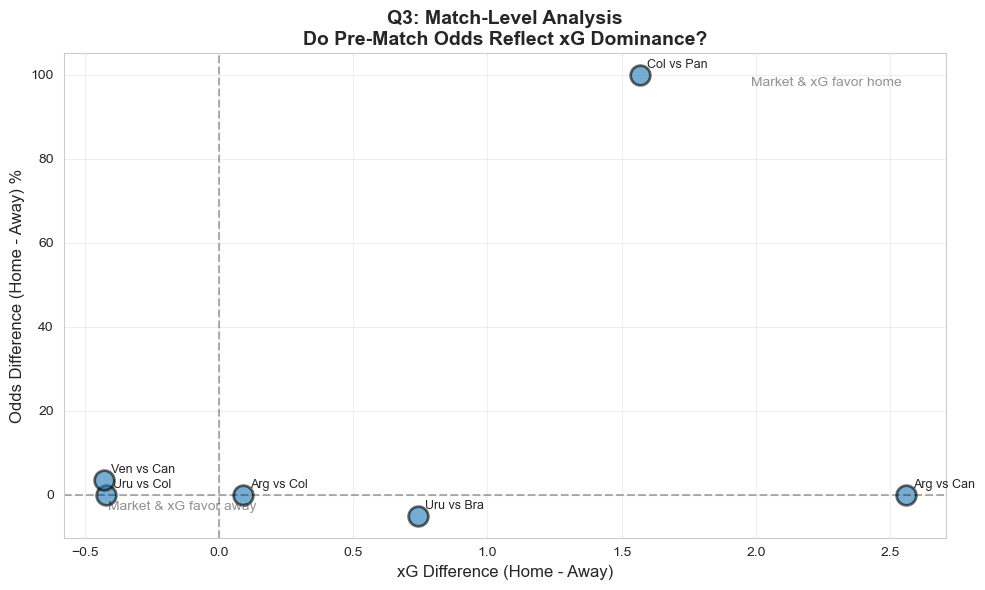


✓ Visualization saved as 'q3_match_level_analysis.png'
✓ Q3 final data exported


In [79]:
# Create simple visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Scatter: xG difference vs odds difference
if 'home_odds' in q3_final.columns and 'home_xg' in q3_final.columns:
    valid = q3_final[['home_odds', 'away_odds', 'home_xg', 'away_xg', 'home_team', 'away_team']].dropna()
    
    if len(valid) > 0:
        valid['odds_diff'] = (valid['home_odds'] - valid['away_odds']) * 100  # Convert to percentage points
        valid['xg_diff'] = valid['home_xg'] - valid['away_xg']
        
        ax.scatter(valid['xg_diff'], valid['odds_diff'], s=200, alpha=0.6, edgecolors='black', linewidths=2)
        
        # Labels
        for idx, row in valid.iterrows():
            match_row = q3_final.loc[idx]
            label = f"{match_row['home_team'][:3]} vs {match_row['away_team'][:3]}"
            ax.annotate(label, (row['xg_diff'], row['odds_diff']), 
                       xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        # Reference lines
        ax.axhline(0, color='black', linestyle='--', alpha=0.3)
        ax.axvline(0, color='black', linestyle='--', alpha=0.3)
        
        ax.set_xlabel('xG Difference (Home - Away)', fontsize=12)
        ax.set_ylabel('Odds Difference (Home - Away) %', fontsize=12)
        ax.set_title('Q3: Match-Level Analysis\nDo Pre-Match Odds Reflect xG Dominance?', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add quadrant labels
        ax.text(0.95, 0.95, 'Market & xG favor home', transform=ax.transAxes, 
               ha='right', va='top', fontsize=10, alpha=0.5)
        ax.text(0.05, 0.05, 'Market & xG favor away', transform=ax.transAxes,
               ha='left', va='bottom', fontsize=10, alpha=0.5)
        
        plt.tight_layout()
        plt.savefig('q3_match_level_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\n✓ Visualization saved as 'q3_match_level_analysis.png'")

# Save final dataset
q3_final.to_csv(DATA_DIR / 'cleaned' / 'q3_match_level_final.csv', index=False)
print("✓ Q3 final data exported")